<p style="color:#FFF; background:#06D; padding:12px; font-size:20px; font-style:italic; text-align:center">
<span style="width:49%; display:inline-block; text-align:left">Version 2025-06</span>
<span style="width:49%; display:inline-block; text-align:right">Licence CC–BY–NC–ND</span>
<span style="font-size:40px; font-style:normal"><b>TRAITEMENT&ensp;DE&ensp;DONNÉES</b></span><br>
<span style="width:49%; display:inline-block; text-align:left">Christophe Schlick</span>
<span style="width:49%; display:inline-block; text-align:right">schlick ಄ u<b>-</b>bordeaux • fr</p>

Lorsque les données ont été extraites, nettoyées et structurées dans des conteneurs Python, l'étape suivante consiste à leur appliquer divers traitements pour ***les analyser, les comprendre et les exploiter*** dans un processus de prise de décision. Les packages **numpy**, **pandas** et **scipy** incluent déjà de nombreux outils pour cette étape, comme on l'a vu dans les chapitres 5, 7 et 9. Mais l'écosystème Scientific Python contient un très grand nombre de bibliothèques supplémentaires destinées à faciliter cette étape d'analyse de données, chacune étant spécialisée dans un type de données ou un type de traitements particuliers. L'ojectif de ce chapitre est de passer en revue quelques unes de ces bibliothèques, en se focalisant sur les plus intéressantes dans le domaine des Sciences des Données.

In [1]:
import warnings; warnings.filterwarnings('ignore') # suppression des 'warning' de l'interpréteur
from SRC.tools import show, load, inspect, cutcut # import des fonctions utilitaires du module 'tools'
import IPython.display as dp, numpy as np, matplotlib.pyplot as mp, seaborn as sb # packages usuels

<h2 style="padding:16px; color:#FFF; background:#06D">A - Package 'statsmodels'</h2>

La bibliothèque **`statsmodels`** est certainement le package de l'écosystème Scientific Python qui fournit la boîte à outils la plus complète en matière d'analyse statistique des données. Elle contient de nombreuses classes et fonctions réparties en trois grandes catégories : des modèles de régression, des méthodes d'estimation et différents modèles de tests statistiques classiques (Student, Welch, khi2, kappa, ANOVA, etc). Une des caractéristiques de **statsmodels** est sa capacité à fournir des résumés détaillés pour les modèles et les tests, ce qui permet d'obtenir une information très complète en un seul appel de fonction, comme on le verra dans les exemples ci-dessous.

Les outils fournis par **statsmodels** sont répartis dans de nombreux modules indépendants, chacun étant spécialisé dans un traitement particulier. Néanmoins, pour simplifier l'utilisation, le package fourni deux modules spécifiques qui regroupent les fonctions les plus classiques, ce qui permet, dans la plupart des cas, de n'avoir qu'à importer ce deux modules :

- **`statsmodels.api`** : regroupe les principaux modèles de régression (habituellement importé avec l'alias **`sm`**)
- **`statsmodels.stats.api`** : regroupe les principaux tests statistiques (habituellement importé avec l'alias **`sms`**)

In [2]:
import statsmodels.api as sm # import du module 'api' de base avec l'alias habituel 'sm'
import statsmodels.stats.api as sms # import du module 'api' de 'stats' avec l'alias habituel 'sms'

Pour pouvoir mettre en oeuvre les outils de **statsmodels**, on va créer un jeu de données artificiel vérifiant un certain nombre de propriétés statistiques. Plus précisément, on va créer trois variables **`x1, x2, x3`** avec des distributions variées, ainsi qu'une fonction de bruit **`e`** représentant l'erreur de mesure qui existe dans les données réelles. Ces variables vont ensuite être combinées pour créer des distributions plus complexes **`yA`** et **`yB`** qu'on va fournir aux différentes fonctions :

In [3]:
np.random.seed(0); n = 2000 # définition du nombre d'échantillons à générer
x1 = np.random.random(n) # variable explicative 1 = distribution uniforme
x2 = np.random.normal(5, 2, n) # variable explicative 2 = distribution normale
x3 = np.random.beta(2, 5, n) # variable explicative 3 = distribution beta
e = np.random.normal(0, 0.5, n) # erreur de mesure = distribution normale de faible variance

yA = 3 + 4*x1 - 2*x2 + 5*x3 + e # combinaison linéaire des variables explicatives avec ajout d'erreur
yB = np.random.gamma(1, np.exp(1 + 1.5*x1 - 0.9*x2 + 0.5*x3)) # distribution gamma à partir des variables
x = sm.add_constant(np.stack([x1, x2, x3]).T) # regroupement des 3 variables et ajout d'une constante

On peut visualiser les distributions des 4 variables obtenues sous la forme d'un histogramme, en mettant en surimpression, la courbe théorique pour la densité de probabilité, selon la distribution choisie :

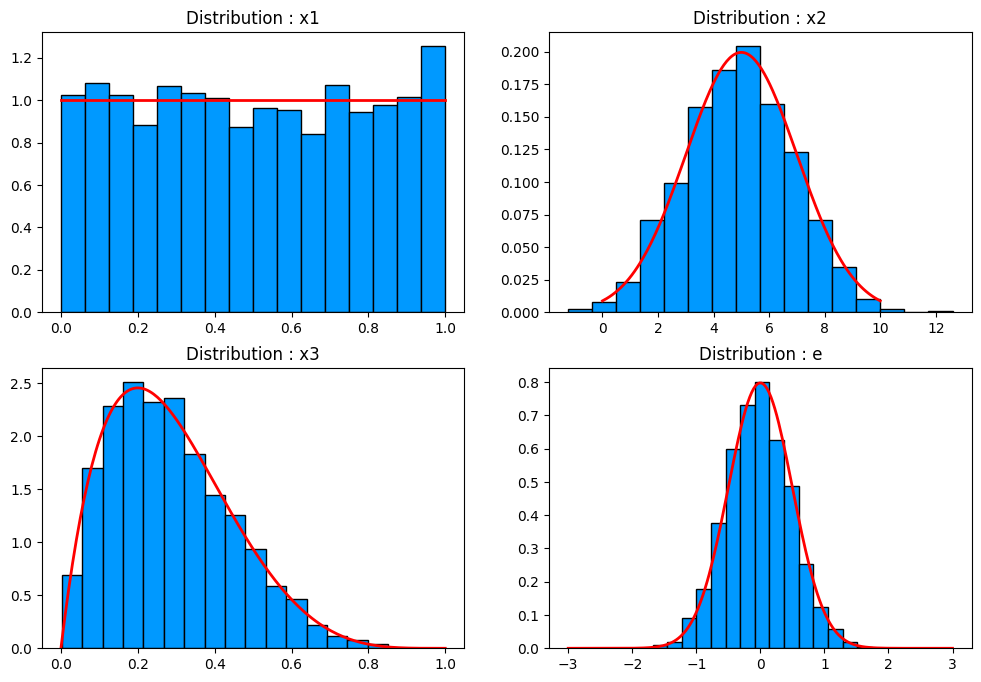

In [4]:
import scipy.stats as st # import du module 'st' de 'scipy' pour le tracé des distributions théoriques

plots = (
  (1, 'x1', x1, np.linspace(0, 1, 200), st.uniform.pdf(np.linspace(0, 1, 200))),
  (2, 'x2', x2, np.linspace(0, 10, 200), st.norm.pdf(np.linspace(0, 10, 200), loc=5, scale=2)),
  (3, 'x3', x3, np.linspace(0, 1, 200), st.beta.pdf(np.linspace(0, 1, 200), a=2, b=5)),
  (4, 'e', e, np.linspace(-3, 3, 200), st.norm.pdf(np.linspace(-3, 3, 200), loc=0, scale=0.5)))

mp.figure(figsize=(12,8), dpi=100)
for p, name, samples, lin, pdf in plots:
  mp.subplot(220+p); mp.hist(samples, bins=16, density=True, color='#09F', edgecolor='k')
  mp.plot(lin, pdf, 'r-', linewidth=2); mp.title(f"Distribution : {name}")

---
### 1 - Régression linéaire par moindres carrées

La fonction **`OLS(y,x)`** implémente une régression linéaire par la méthode des moindres carrés (**OLS** pour ***Ordinary Least Squares***). Cela consiste à estimer les coefficients de pondération d'une combinaison linéaire reliant une variable $y$ à une série de variables explicatives $x$. Avec le jeu de données défini ci-dessus, on va tenter d'approximer les distributions **`yA`** et **`yB`** à partir de la variable **`x`** correspondant à la combinaison des trois variables explicatives et d'une constante. La méthode **`fit`** permet d'effectuer la régression et la méthode **`summary`** en résume les différents paramètres. Comme on peut le constater sur les tableaux récapitulatifs, les résultats obtenus pour ces deux distributions sont très différents :

- La régression OLS sur **`yA`** donne une approximation de très haute qualité : le [**coefficient de détermination**](https://fr.wikipedia.org/wiki/Coefficient_de_d%C3%A9termination) de Pearson $R^2 = 0.986$ ce qui signifie que presque 99% de la variance de la distribution est expliquée par les variables **`x1,x2,x3`** ce qui est confirmé par la valeur très élevé du coefficient de Fisher $F$. Tous les coefficients des variables explicatives sont hautement significatifs (avec des p-valeurs égales à 0) et les estimations de ces paramètres sont très proches de ceux utilisés pour créer la distribution **`yA`** : la constante est estimé à 2.98 (la vraie valeur est 3), les coefficient des trois variables explicatives sont estimés à 4.05, -2.00 et 4.92 (alors que les vraies valeurs sont respectivement à 4, -2 et 5)

- La régression OLS sur **`yB`**, par contre, donne une approximation assez médiocre : le coefficient de Pearson $R^2 = 0.113$ donc moins d'un huitième de la variance est expliqué par les 3 variables explicatives, ce qui est confirmé par une valeur très faible du coefficient de Fisher $F$. La variable **`x1`** est considérée comme non-significative avec une p-valeur élevée, alors que c'est celle qui a le plus grand coefficient de pondération dans l'expression de **`yB`**. Enfin, la valeur très élevée du paramètre [**Jarque-Bera**](https://fr.wikipedia.org/wiki/Test_de_Jarque-Bera) indique que la forme de la distribution est très éloignée d'une distribution normale

Ces résultats ne sont pas surprenants au regard des distributions initiales : **`yA`** est une combinaison linéaire de distributions [**uniforme**](https://fr.wikipedia.org/wiki/Loi_uniforme_continue), [**normale**](https://fr.wikipedia.org/wiki/Distribution_normale) et [**bêta**](https://fr.wikipedia.org/wiki/Loi_b%C3%AAta), ce qui est très bien approximé par une somme pondérée de fonctions gaussiennes mis en oeuvre par le mécanisme des moindres carrés. A l'inverse, **`yB`** est une distribution [**gamma**](https://fr.wikipedia.org/wiki/Loi_Gamma) dont la forme est plus éloignée d'une somme de gaussiennes et qui est donc assez mal approximée par les moindres carrées

In [5]:
olsA, olsB = sm.OLS(yA, x).fit(), sm.OLS(yB, x).fit() # calcul des régressions par moindres carrés
show("olsA.summary();;olsB.summary()") # affichage des paramètres des deux régressions

olsA.summary() ➤                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 4.556e+04
Date:                Mon, 04 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:49:44   Log-Likelihood:                -1470.4
No. Observations:                2000   AIC:                             2949.
Df Residuals:                    1996   BIC:                             2971.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9773      0.042   

L'affichage des densités de probabilité pour les données initiales **`yA`** et **`yB`** et les données approximées par la régression **`fA`** et **`fB`**, illustre bien la différence de qualité entre les régressions obtenues pour les deux distributions :

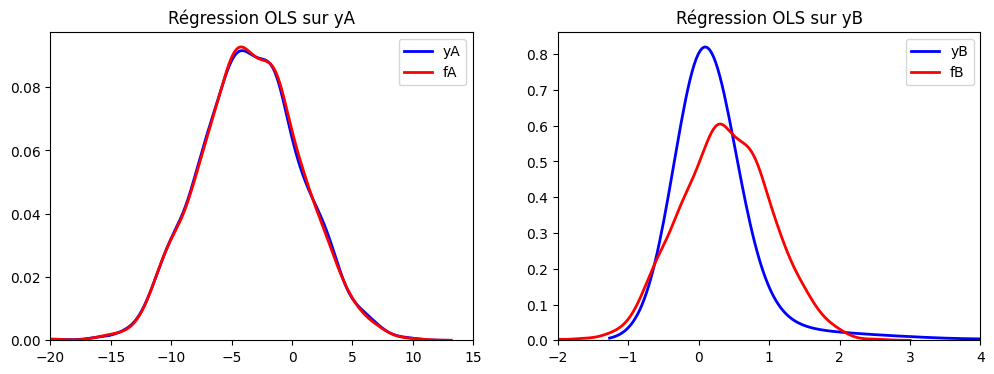

In [6]:
fA, fB = olsA.fittedvalues, olsB.fittedvalues # extraction des valeurs obtenues par régression
mp.figure(figsize=(12,4), dpi=100) # affichage des densités de probabilité (initiales et après régression)
mp.subplot(121); mp.xlim(-20,15); mp.title(f"Régression OLS sur yA")
sb.kdeplot(yA, color='b', lw=2, gridsize=2000, label='yA');
sb.kdeplot(fA, color='r', lw=2, gridsize=2000, label='fA'); mp.ylabel(''); mp.legend()
mp.subplot(122); mp.xlim(-2,4); mp.title(f"Régression OLS sur yB")
sb.kdeplot(yB, color='b', lw=2, gridsize=2000, label='yB');
sb.kdeplot(fB, color='r', lw=2, gridsize=2000, label='fB'); mp.ylabel(''); mp.legend();

---
### 2 - Régression linéaire généralisée

La fonction **`GLM(y,x)`** implémente une régression linéaire généralisée (**GLM** pour ***Generalized Linear Models***). Il s'agit d'une extension de la méthode OLS, dans laquelle l'utilisateur peut spécifier, via le paramètre **`family`**, la famille de fonctions à utiliser pour la régression (appelée ***fonctions de base***) et, via le paramètre **`link`**, la fonction de transformation à utiliser pour l'estimation (appelée ***fonction de lien***). Par défaut la fonction **`GLM`** utilise des gaussiennes comme fonctions de base, et l'identité comme fonction de lien, ce qui correspond exactement à une méthode des moindres carrés standard. Voici les résultats obtenus avec la régression linéaire généralisée, dans le cas des distributions **`yA`** et **`yB`** :

- La régression GLM sur **`yA`** a été mise en oeuvre avec les valeurs par défaut de la fonction **`GLM`** et, comme on peut le constater, on obtient exactement les mêmes résultats qu'avec la régression OLS. Ce n'est pas une surprise, puisque les paramètres par défaut de GLM correspondent justement à la méthode OLS.

- La régression GLM sur **`yB`**, par contre, donne de bien meilleurs résultats que ceux obtenus précédemment avec la régression OLS. On utilise ici, les fonctions gamma comme fonctions de base pour la régression, et une transformation logarithmique comme fonction de lien. Comme on peut le constater, le paramètre de Pearson $R^2 = 0.956$ montre que plus de 95% de la variance de la distribution est expliquée par le modèle. Tous les coefficients des variables explicatives sont hautement significatifs et on peut voir que les estimations de ces paramètres sont très proches de ceux utilisés pour créer la distribution **`yB`** : la constante est estimé à 1.02 (la vraie valeur est 1), les coefficient des variables sont estimés à 1.49, -0.89 et 0.34 (alors que les vraies valeurs sont respectivement à 1.5, -0.9 et 0.5). Le coefficient de **`x3`** est donc un peu sous-estimé, ce qui est cohérent avec une p-valeur plus grande que les autres (0.015 au lieu de 0 pour **`x1`** et **`x2`**)

In [7]:
glmA = sm.GLM(yA, x).fit() # configuration par défaut (family=gaussian, link=identity)
glmB = sm.GLM(yB, x, family=sm.families.Gamma(link=sm.families.links.log())).fit() # family=gamma, link=log
show("glmA.summary();;glmB.summary()") # affichage des paramètres des deux régressions

glmA.summary() ➤                  Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 2000
Model:                            GLM   Df Residuals:                     1996
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                         0.25526
Method:                          IRLS   Log-Likelihood:                -1470.4
Date:                Mon, 04 Aug 2025   Deviance:                       509.49
Time:                        21:49:46   Pearson chi2:                     509.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9773      0.042   

L'affichage des densités de probabilité pour les données initiales **`yA`** et **`yB`** et les données approximées par la régression généralisée **`gA`** et **`gB`**, montre le saut qualitatif obtenu pour **`yB`** :

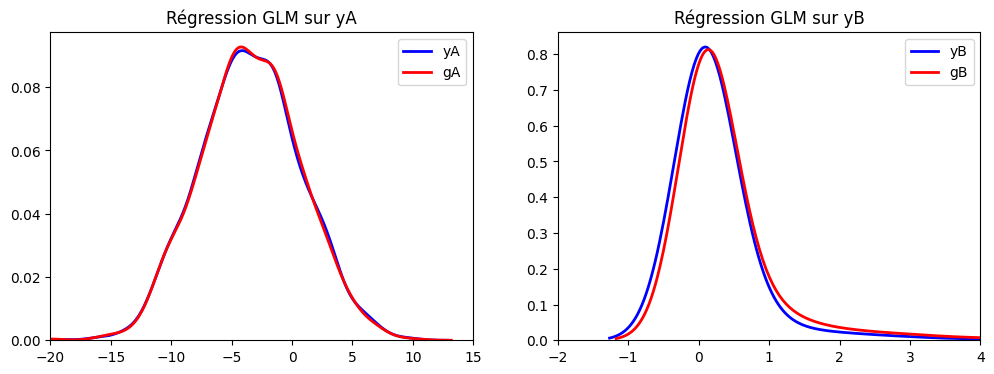

In [8]:
gA, gB = glmA.fittedvalues, glmB.fittedvalues*1.4 # extraction des valeurs obtenues par régression
mp.figure(figsize=(12,4), dpi=100) # affichage des densités de probabilité (initiales et après régression)
mp.subplot(121); mp.xlim(-20,15); mp.title(f"Régression GLM sur yA")
sb.kdeplot(yA, color='b', lw=2, gridsize=2000, label='yA');
sb.kdeplot(gA, color='r', lw=2, gridsize=2000, label='gA'); mp.ylabel(''); mp.legend()
mp.subplot(122); mp.xlim(-2,4); mp.title(f"Régression GLM sur yB")
sb.kdeplot(yB, color='b', lw=2, gridsize=2000, label='yB');
sb.kdeplot(gB, color='r', lw=2, gridsize=2000, label='gB'); mp.ylabel(''); mp.legend();

---
### 3 - Régression logistique

La fonction **`Logit(y,x)`** implémente une régression logistique permettant d'estimer le comportement d'une variable binaire **`y`** en fonction des variables explicatives **`x`**. La variable **`y`** suit nécessairement une [**distribution de Bernoulli**](https://fr.wikipedia.org/wiki/Loi_de_Bernoulli) (autrement dit, elle ne peut prendre que les valeurs 0 ou 1) alors que les variables explicatives **`x`** peuvent être continues, discrètes ou binaires. Depuis le développement des techniques d'apprentissage automatique, la régression logistique est devenue l'une des méthodes statistiques les plus utilisées en Sciences des Données, notamment parce qu'elle est particulièrement bien adaptée à la création d'outils de classifications automatiques.

Pour tester la fonction **`Logit`**, on va à nouveau créer un jeu de données artificiel, cette fois-ci composé de deux distributions de Bernoulli **`yC`** et **`yD`** : la première utilise une loi binomiale avec une fonction de probabilité logistique dont on sait qu'elle est bien adaptée aux techniques de classification binaire, la seconde distribution utilise une simple fonction trigonométrique seuillée, sans propriétés particulières. Pour visualiser les distributions, on va projeter les échantillons successivement sur les trois plans ***(x1,x2)***, ***(x2,x3)*** et ***(x3,x1)*** en affichant un disque rouge lorsque l'échantillon vaut 0 et un disque bleu lorsque l'échantillon vaut 1. Comme on peut le constater sur les figures ci-dessous, la distribution **`yC`** semble avoir une bonne séparabilité sur certains axes, ce qui laisse augurer un bon résultat pour une régression logistique, alors que pour **`yD`**, les deux couleurs sont systématiquement mélangées, ce qui ne laisse guère d'espoir pour une classification efficace :

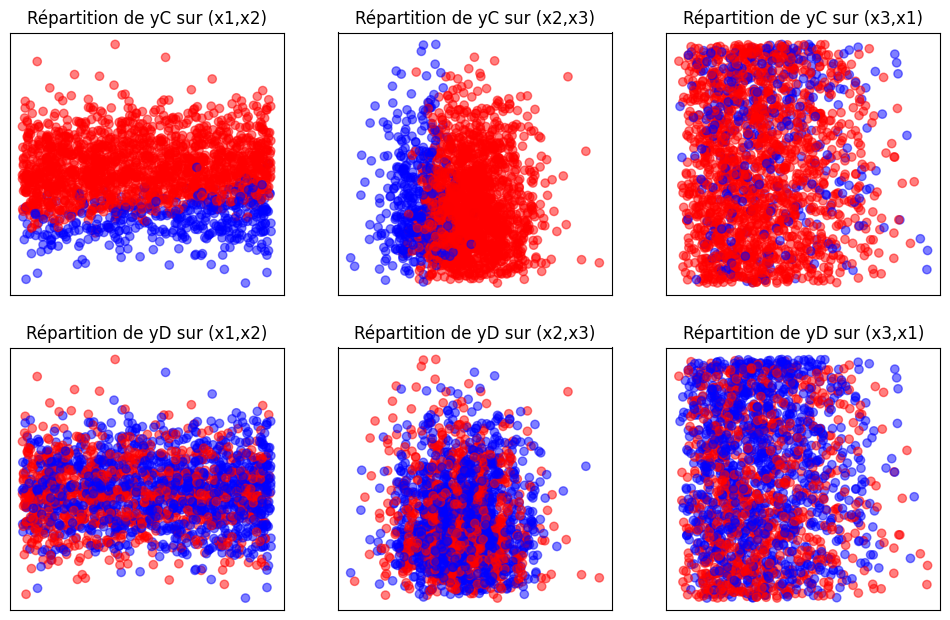

In [9]:
# distributions de Bernoulli (pour régressions logistiques)
yC = np.random.binomial(1, 1 / (1 + np.exp(-5 - 6*x1 + 3*x2 - 4*x3))) # distribution binomiale logistique
yD = (np.sin(2*x1) + np.cos(5*x2 - 4*x3) + np.random.normal(0, 1, n)) > 0.5 # seuillage de fonction trigo

mp.figure(figsize=(12,7.5), dpi=100) # répartitions des échantillons selon les variables x1, x2 et x3
colorC, colorD = ['rb'[y] for y in yC], ['rb'[y] for y in yD] # couleur rouge pour y = 0 et bleu pour y = 1
mp.subplot(231); mp.scatter(x1, x2, c=colorC, alpha=0.5)
mp.xticks(()); mp.yticks(()); mp.title(f"Répartition de yC sur (x1,x2)")
mp.subplot(232); mp.scatter(x2, x3, c=colorC, alpha=0.5)
mp.xticks(()); mp.yticks(()); mp.title(f"Répartition de yC sur (x2,x3)")
mp.subplot(233); mp.scatter(x3, x1, c=colorC, alpha=0.5)
mp.xticks(()); mp.yticks(()); mp.title(f"Répartition de yC sur (x3,x1)")
mp.subplot(234); mp.scatter(x1, x2, c=colorD, alpha=0.5)
mp.xticks(()); mp.yticks(()); mp.title(f"Répartition de yD sur (x1,x2)")
mp.subplot(235); mp.scatter(x2, x3, c=colorD, alpha=0.5)
mp.xticks(()); mp.yticks(()); mp.title(f"Répartition de yD sur (x2,x3)")
mp.subplot(236); mp.scatter(x3, x1, c=colorD, alpha=0.5)
mp.xticks(()); mp.yticks(()); mp.title(f"Répartition de yD sur (x3,x1)");

Les tableaux ci-dessous présentent les caractéristiques de la régression logistique obtenue sur les distributions **`yC`** et **`yD`** :

- La régression Logit sur **`yC`** donne d'excellents résultats, avec un paramètre de Pearson $R^2 = 0.716$ montre que plus de 71% de la variance de la distribution est expliquée par le modèle (il faut rappeler que pour les régressions logistiques, le $R^2$ est généralement moins haut que pour les régressions linéaire). Tous les coefficients des variables explicatives sont hautement significatifs (avec une p-valeur nulle) et on peut voir que les estimations de ces paramètres sont très proches de ceux utilisés pour créer la distribution **`yC`** : la constante est estimé à 4.55 (la vraie valeur est 5), les coefficient des variables sont estimés à 6.50, -2.98 et 4.20 (alors que les vraies valeurs sont respectivement à 6, -3 et 4)

- A l'inverse, la régression Logit sur **`yD`** est catastrophique, avec un paramètre de Pearson $R^2 = 0.032$, autrement dit, les variables utilisées par le modèle n'expliquent quasiment rien. Ce qui est confirmé par le log-likehood (vraisemblance logarithmique) qui ne montre aucune amélioration par le modèle (-1373 sans modèle, -1329 avec modèle). On est ici typiquement dans un cas où la régression n'arrive pas  à effectuer une séparation des échantillons

In [10]:
lgtC, lgtD = sm.Logit(yC, x).fit(), sm.Logit(yD, x).fit() # calcul des régressions logistiques
show("lgtC.summary();; lgtD.summary()") # affichage des paramètres des deux régressions

Optimization terminated successfully.
         Current function value: 0.147740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665941
         Iterations 4
lgtC.summary() ➤                            Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1996
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.7014
Time:                        21:49:48   Log-Likelihood:                -295.48
converged:                       True   LL-Null:                       -989.61
Covariance Type:            nonrobust   LLR p-value:                1.034e-300
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

Pour avoir une compréhension plus intuitive des résultats des régressions, on peut afficher les histogrammes des prédictions. Pour cela, on va extraire les valeurs prédites **`hC`** et **`hD`** par le modèle obtenu après régression logistique, et les comparer aux valeurs exactes fournies par les distributions initiales **`yC`** et **`yD`**. En associant les mêmes couleurs que précédemment (rouge pour 0, bleu pour 1), un histogramme des prédiction parfait devrait être composé d'une unique colonne rouge à gauche et d'une unique colonne bleue à droite. Mais en pratique, il y aura toujours des faux négatifs (des échantillons bleues qui seront classés à gauche) et des faux positifs (des échantillons rouges qui seront classés à droite).

Sur les deux distributions testées, on constate que les valeurs prédites **`hC`**, obtenues par la régression logistique sur **`yC`**, donnent une classification de très grande qualité, avec moins de 5% de prédictions erronées, alors que celles prédites par **`hD`** donnent un résultat à peine meilleur qu'une classification purement aléatoire avec 40% de prédictions erronées :

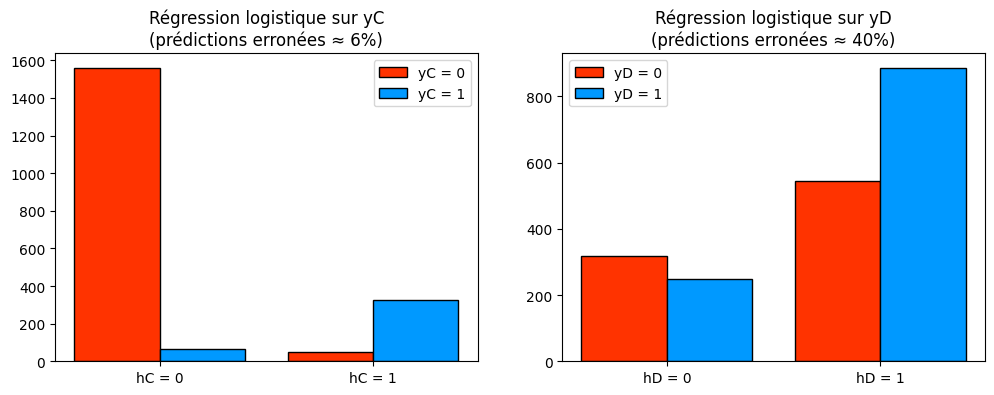

In [11]:
hC, hD = lgtC.predict(), lgtD.predict() # extraction des valeurs prédites obtenues par régression logistique
hC0, hD0 = hC[yC==0] > 0.5, hD[yD==0] > 0.5 # valeurs prédites pour lesquelles la valeur correcte est 0
hC1, hD1 = hC[yC==1] > 0.5, hD[yD==1] > 0.5 # valeurs prédites pour lesquelles la valeur correcte est 1
errC, errD = (hC0.sum()+(~hC1).sum()) / len(yC), (hD0.sum()+(~hD1).sum()) / len(yD) # taux d'erreurs

mp.figure(figsize=(12,4), dpi=100) # affichage des valeurs prédites (correctes ou erronées)
mp.subplot(121); mp.title(f"Régression logistique sur yC\n(prédictions erronées ≈ {errC:.0%})")
mp.hist((hC0,hC1), bins=(-1/2,1/2,3/2), color=('#F30','#09F'), edgecolor='k', label=('yC = 0','yC = 1'))
mp.xticks([0, 1], ['hC = 0', 'hC = 1']); mp.legend()
mp.subplot(122); mp.title(f"Régression logistique sur yD\n(prédictions erronées ≈ {errD:.0%})")
mp.hist((hD0,hD1), bins=(-1/2,1/2,3/2), color=('#F30','#09F'), edgecolor='k', label=('yD = 0','yD = 1'))
mp.xticks([0, 1], ['hD = 0', 'hD = 1']); mp.legend();

---
### 4 - Analyse en composantes principales

La fonction **`multivariate.PCA(x)`** réalise une [**analyse en composantes principales**](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales) (***Principal Component Analysis***) sur un jeu de données multivariées **`x`**, ce qui consiste à identifier les ***axes de plus grande variance*** dans ce jeu de données. L'utilisation principale de la méthode PCA est de réduire la dimension de l'espace des paramètres d'une fonction multivariée, en identifiant un sous-groupe de variables (généralement, on en conserve 2 ou 3) qui va contenir la majeure partie de la variance des données initiales. A l'arrivée, cela permet d'étudier la fonction multivariée **`y`** dans un espace bidimensionnel ou tridimensionnel, plutôt que dans un espace de dimension **n**.

Il est important de rappeler que les valeurs de la fonction **`y`** que l'on cherche à expliquer avec les variables **`x`** ne sont pas utilisées par la PCA (autrement dit, il s'agit d'une ***méthode non-supervisée*** si on utilise le vocabulaire des Sciences des Données). Les axes fournis par la PCA sont appelés ***composantes principales*** ou ***axes principaux*** et vont toujours être des combinaisons linéaires des variables initiales. Le résultat d'une PCA est retourné sous la forme d'un objet Python composé de plusieurs attributs : **`loadings`** contient les coefficients de pondération des combinaisons linéaires permettant de déterminer les axes principaux par rapport aux variables initiales, **`factors`** contient la projection des données sur chacun des axes principaux, et enfin **`rsquare`** qui regroupe les coefficients de Pearson correspondant à la proportion de variance expliquée pour chacun des axes principaux.

> **Note :**  Il existe des méthodes alternatives à la PCA qui sont dites ***supervisées*** car elle combinent les données de **`x`** et celles de **`y`** pour chercher les axes qui maximisent la covariance entre ces deux jeux de données. Ces méthodes (**Partial Least Squares** pour les données continues ou **Linear Discriminant Analysis** pour les données discrètes) ne sont pas disponibles dans le package **`statsmodels`**, mais pourront être trouvées dans des bibliothèques plus spécialisées dans l'apprentissage automatique, telles que [**scikit-learn**]() par exemple

Si on applique la fonction PCA sur nos trois variables explicatives **`x1,x2,x3`**, on obtient trois axes principaux **`p1,p2,p3`** qui sont parfaitement équilibrés puisque les coefficients de détermination de Pearson associés sont quasiment égaux à 1/3 pour chacun des axes (34.1%, 33.3% et 32.6% respectivement) :

In [12]:
samples = np.stack([x1,x2,x3]).T # fusion des échantillons des 3 variables explicatives x1, x2, x3
pca = sm.multivariate.PCA(samples, ncomp=3, standardize=True) # recherche des 3 composantes principales
p1, p2, p3 = pca.factors.T # projection des données sur les 3 axes principaux obtenus par la PCA

for k,(a,b,c) in enumerate(pca.loadings.T): # affichage des combinaisons linéaires définissant les 3 axes
  print(f"p{k+1} = {a:+.3f}*x1 {b:+.3f}*x2 {c:+.3f}*x3", end=' ') # combinaisons linéaires de x1, x2, x3
  print(f"(avec r-square = {pca.rsquare[k+1] - pca.rsquare[k]:.2%})") # affichage du coeff de détermination

p1 = -0.269*x1 -0.664*x2 +0.697*x3 (avec r-square = 34.12%)
p2 = -0.946*x1 +0.317*x2 -0.064*x3 (avec r-square = 33.30%)
p3 = +0.179*x1 +0.677*x2 +0.714*x3 (avec r-square = 32.58%)


Le fait d'avoir trois coefficients de détermination équilibrés signifie que les échantillons sont intrinsèquement des données tridimensionnelles, et que si on les projette sur un plan, on va perdre environ un tiers de l'information. Ceci est illustré sur la figure ci-dessous, qui montre la projection des échantillons sur le plan **(p1,p2)** en les coloriant par rapport à la valeur de la distribution **`yA`** associée à chaque échantillons, via une colormap **`jet`** : on constate que les valeurs de **`yA`** sont globalement classés selon la diagonale principale, mais que ce classement n'est pas parfait, puisqu'une même zone peut mélanger des couleurs variées, et donc des valeurs de **`yA`** assez différentes :

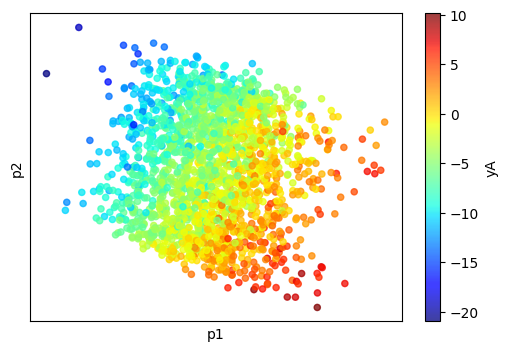

In [13]:
mp.figure(figsize=(6, 4)); mp.scatter(p1, p2, c=yA, cmap='jet', s=20, alpha=0.75)
mp.xticks(()); mp.yticks(()); mp.xlabel('p1'); mp.ylabel('p2'); mp.colorbar(label='yA');

Une astuce classique pour améliorer une PCA, consiste à rajouer artificillement des variables supplémentaires, obtenues par combinaisons linéaires des variables initiales. Ces variables ne vont évidemment pas apporter d'information additionnelle, mais elles permettent d'obtenir des degrés de liberté supplémentaires qui vont être utilisés par la PCA pour obtenir des axes principaux plus discriminants. Dans notre cas, on va créer trois nouvelles variables **`x4,x5,x6`** à partir de **`x1,x2,x3`** puis effectuer une PCA sur ces six axes. Comme on peut le constater ci-dessous, le processus nous donne 6 axes principaux **`p1,p2,p3,p4,p5,p6`** mais les trois derniers ne servent à rien puisqu'ils donnent tous un coefficient de Pearson égal à 0. Par contre, les trois premiers axes sont maintenant clairement triés par ordre d'importance avec des $R^2$ respectifs égaux à 48.9%, 33.4% et 17.7%. Autrement dit, les deux premiers axes regroupent plus de 83% de la variance totale :

In [14]:
x4, x5, x6 = x1-3*x2, x2-3*x3, x3-3*x1 # création de 3 variables par combinaisons linéaires de x1,x2,x3
x4, x5, x6 = x1-5*x2, x2-5*x3, x3-5*x1 # création de 3 variables par combinaisons linéaires de x1,x2,x3
pca = sm.multivariate.PCA(np.stack([x1,x2,x3,x4,x5,x6]).T, ncomp=6, standardize=True) # calcul de la PCA
p1, p2, p3, p4, p5, p6 = pca.factors.T # extraction des 6 axes trouvés

for k,(a,b,c,d,e,f) in enumerate(pca.loadings.T): # affichage des combinaisons linéaires pour les 6 axes
  print(f"p{k+1} = {a:+.3f}*x1 {b:+.3f}*x2 {c:+.3f}*x3 {d:+.3f}*x4 {e:+.3f}*x5 {f:+.3f}*x6", end=' ')
  print(f"(avec r-square = {pca.rsquare[k+1] - pca.rsquare[k]:.2%})")

p1 = +0.002*x1 +0.572*x2 -0.131*x3 -0.571*x4 +0.574*x5 -0.016*x6 (avec r-square = 48.94%)
p2 = -0.701*x1 +0.019*x2 +0.091*x3 -0.041*x4 -0.016*x5 +0.706*x6 (avec r-square = 33.40%)
p3 = +0.121*x1 +0.195*x2 +0.939*x3 -0.191*x4 -0.172*x5 -0.020*x6 (avec r-square = 17.66%)
p4 = +0.450*x1 +0.035*x2 +0.148*x3 +0.523*x4 +0.530*x5 +0.469*x6 (avec r-square = 0.00%)
p5 = +0.434*x1 +0.431*x2 -0.268*x3 -0.114*x4 -0.593*x5 +0.434*x6 (avec r-square = -0.00%)
p6 = -0.321*x1 +0.669*x2 +0.001*x3 +0.591*x4 -0.086*x5 -0.305*x6 (avec r-square = 0.00%)


Lorsqu'on projette les valeurs de **`yA`** sur le plan défini par ces deux nouveaux axes ***(p1,p2)***, on constate que les données sont beaucoup mieux organisées : d'une part, si on fait abstraction de quelques outliers, les données sont globalement réparties de manière homogènes dans un rectangle aligné sur les deux axes, et d'autre part, les couleurs forment très clairement un dégradé horizontal, ce qui signifique que les valeurs de **`yA`** sont presque parfaitement classées le long de l'axis **`p1`** :

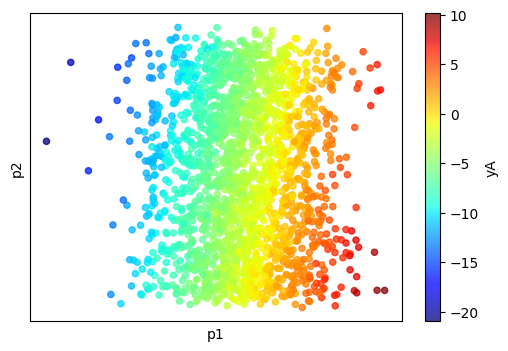

In [15]:
mp.figure(figsize=(6, 4)); mp.scatter(-p1, p2, c=yA, cmap='jet', s=20, alpha=0.75)
mp.xticks(()); mp.yticks(()); mp.xlabel('p1'); mp.ylabel('p2'); mp.colorbar(label='yA');

---
### 5 - Test de Student et test de Welch

La fonction **`sms.ttest_ind(a,b)`** effectue un T-test de Student/Welch. Concrêtement, elle compare les moyennes de deux groupes d'échantillons indépendants **`a`** et **`b`** afin d'évaluer s’il existe une différence statistiquement significative entre elles. La fonction possède un paramètre optionel **`usevar`** qui permet de contrôler le test en donnant des indications sur les tailles et les variances des deux groupes : ***'pooled'*** (valeur par défaut) indique que les tailles et les variances des groupes sont similaires (ce qui va correspondre à un [**test de Student**](https://fr.wikipedia.org/wiki/Test_de_Student)) et ***'unequal'*** indique que soit les tailles, soit les variances sont très différentes (ce qui va correspondre à un [**test de Welch**](https://fr.wikipedia.org/wiki/Test_t_de_Welch)). Dans tous les cas, la fonction retourne un tuple de trois paramètres :

- `tstat`, appelé **statistique-t**, mesure l’écart entre les deux moyennes, rapporté à la variabilité des échantillons
- `pval`,  appelé **p-valeur**, représente la probabilité d’obtenir un tel écart si les deux groupes avaient la même moyenne
- `dof`, appelé **degrés de liberté** (***degrees of freedom***), qui détermine la forme de la distribution utilisée pour calculer la p-valeur (plus le paramètre est élevé, plus la distribution ressemble à une loi normale)

Pour tester la fonction, on va reprendre les distributions binaires **`yC`** et **`yD`**, et analyser les relations entre les variables explicatives et les valeurs des échantillons. Sur la figure montrant la projections du nuage de points sur les plans ***(x1,x2)***, ***(x2,x3)*** et ***(x3,x1)*** (cf. paragraphe 3 ci-dessus), on a vu que les valeurs de **`yC`** étaient fortement séparables par rapport à la variable **`x2`**, et à l'inverse, que les valeurs de **`yD`** étaient totalement mélangées le long de l'axe **`x3`**. L'application du T-test sur ces données va confirmer numériquement cette observation purement visuelle :

- Le premier T-test (**`x2`** selon **`yC`**) donne une grande valeur pour $t = 46.766$ avec une p-valeur quasi-nulle pour $p$, ce qui signifie qu’il existe une **différence très significative** de moyenne pour **`x2`** entre les groupes **`yC = 0`** et **`yC = 1`**. Autrement dit, **`x2`** est fortement discriminant pour prédire les valeurs de **`yC`**, ce qui est cohérent avec la manière dont **`yC`** a été généré

- Le second T-test (**`x3`** selon **`yD`**) donne une faible valeur pour $ = -0.611$ avec une p-valeur non significatif $p = 0.541$, ce qui implique qu'il n’y a **aucune différence significative** entre les moyennes de **`x3`** pour les groupes **`yD = 0`** et **`yD = 1`**. Donc **`x3`** n'est pas discriminant pour prédire les valeurs de **`yD`**, là encore, c'est cohérent avec la construction de la distribution **`yD`**

In [16]:
tstat, pval, dof = sms.ttest_ind(x2[yC == 0], x2[yC == 1], usevar='unequal')
print(f"T-test pour x2 sur yC : t = {tstat:.3f} avec p = {pval:.3f}")

tstat, pval, dof = sms.ttest_ind(x3[yD == 0], x3[yD == 1], usevar='unequal')
print(f"T-test pour x3 sur yD : t = {tstat:.3f} avec p = {pval:.3f}")

T-test pour x2 sur yC : t = 46.766 avec p = 0.000
T-test pour x3 sur yD : t = -0.611 avec p = 0.541


<h2 style="padding:16px; color:#FFF; background:#06D">B - Package 'cxvpy'</h2>

L'[**optimisation**](https://fr.wikipedia.org/wiki/Optimisation_(math%C3%A9matiques)) est un domaine au sein des mathématiques qui vise à développer des méthodes analytiques ou numériques, permettant d'obtenir la valeur optimale pour une fonction multivariée, en respectant un ensemble de contraintes sur les variables associées. Dans la plupart des cas, un processus d'optimisation consiste à **minimiser ou maximiser une fonction objectif** dont la nature dépend du problème à résoudre (par exemple, minimiser une fonction d'erreur ou de coût, maximiser une fonction de profit ou de rendement, etc). De même, les contraintes sont presque toujours exprimées sous la forme d'un **ensemble d'égalités ou d'inégalités** entre des expressions algébriques sur les variables. Selon la nature de la fonction objectif et celle des contraintes, différentes familles de méthodes de résolution ont été développées :

- **Optimisation Linéaire** (en anglais, *Linear Programming* ou ***LP***) concerne les problèmes où la fonction objectif et les contraintes mettent en oeuvre des ***expressions linéaires*** sur les variables

- **Optimisation Quadratique** (*Quadratic Programming* ou ***QP***) lorsque la fonction objectif est définie par une ***expression quadratique*** tandis que les contraintes restent linéaires

- **Optimisation Quadratique à Contraintes Quadratiques** (*Quadratically Constrained Quadratic Programming* ou ***QCQP***) lorsque la fonction objectif mais également les contraintes sont définies par des ***expressions quadratiques***

- **Optimisation en Nombres Entiers** (*Integer Programming* ou ***IP***) lorsque ***toutes les variables sont à valeurs entières***. Les problèmes d'optimisation en nombres entiers peuvent se diviser en ***LIP*** (linéaire) ou ***QIP*** (quadratique) mais la quasi-totalité des cas concrets n'utilisent que des contraintes et objectifs linéaires

- **Optimisation Binaire** (*Binary Integer Programming* ou ***BIP***) lorsque ***toutes les variables sont booléennes*** est un cas particulier (assez fréquent) de l'optimisation en nombres entiers

- **Optimisation Mixte en Nombres Entiers** (*Mixed-Integer Programming* ou ***MIP***) lorsque le problème combine des variables à ***valeurs réelles*** et d'autres à ***valeurs entières***. Comme pour les nombres entiers, les problèmes d'optimisation mixtes peuvent se diviser en ***MILP*** (linéaire) ou ***MIQP*** (quadratique)

- **Optimisation Non Linéaire** (*Non-Linear Programming* ou ***NLP***) inclut tous les problèmes où la fonction objectif n'est ni linéaire ni quadratique (par exemple, cubique, quartique, exponentielle, logarithmique, etc)

- **Optimisation Stochastique** (*Stochastic Optimization* ou **SO**) lorsque certaines variables du problème à résoudre ne sont pas déterministes mais stochastiques

> **Note :** Le terme ***programming*** utilisé dans les noms des méthodes, ne signifie pas **programmation** mais **planification**. Ainsi, même si le terme **programmation linéaire** est (encore trop souvent) utilisé par certains auteurs en français, il est fortement recommandé d'employer le terme ***optimisation*** pour éviter la confusion avec le concept de programmation, au sens algorithmique ou informatique

Optimiser une fonction avec contraintes est un objectif qui apparait très fréquemment dans le domaine des Sciences des Données, ce qui explique que l'écosystème **Scientific Python** inclut de très nombreuses bibliothèques pour résoudre ce type de problèmes. La plupart de ces bibliothèques sont capables de gérer plusieurs familles de méthodes parmi celles listées ci-dessus. Voici les principaux packages, avec le lien vers le site officiel et l'énumération des méthodes disponibles :

- [**cvxpy**](https://www.cvxpy.org), [**gurobi**](https://www.gurobi.com), [**cplex**](https://www.ibm.com/products/ilog-cplex-optimization-studio) : LP, IP, BIP, MIP, QP, QCQP
- [**scipy.optimize**](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) : LP, IP, BIP, MIP, NLP
- [**cvxopt**](https://cvxopt.org), [**pyomo**](https://www.pyomo.org) : LP, QP, QCQP
- [**pulp**](https://coin-or.github.io/pulp),  [**python-mip**](https://www.python-mip.com), [**glpk**](https://www.gnu.org/software/glpk) : LP, IP, BIP, MIP
- [**ipopt**](https://coin-or.github.io/Ipopt/), [**nevergrad**](https://facebookresearch.github.io/nevergrad), [**deap**](https://deap.readthedocs.io/) : NLP, SO

Il faut noter que tous ces packages sont directement disponibles sur l'environnement **JupyterHub** du CREMI, par contre seul **scipy.optimize** est installé par défaut avec la distribution Anaconda. Donc pour pouvoir utiliser les autres modules sur votre poste personnel, il faudra les installer dans votre environnement, avec la commande **pip** ou **conda**. Par ailleurs, les packages **gurobi** et **cplex** (capables de résoudre des problèmes à plusieurs milliers de variables) sont des produits commerciaux qui imposent une licence pour leur utilisation, licence qui est déjà activée dans la version installée au CREMI.

Les paragraphes suivants montrent trois exemples concrets de problèmes d'optimisation, dans les cas linéaire, quadratique et mixte, illustrés avec l'utilisation des bibliothèques **cxvpy** et **scipy.optimize**. Comme on pourra le constater, grâce à sa syntaxe extrêmement claire et concise, le package **cvxpy** permet de résoudre chacun de ces exemples en quelques lignes de code, et s'avère donc être particulièrement intéressant pour une grande variété de problèmes d'optimisation.

---
### 1 - Exemple d'optimisation linéaire

On cherche à optimiser les coûts de fonctionnement d'une usine comprenant quatre chaînes de production $\cal A$, $\cal B$, $\cal C$ et $\cal D$ dont voici la liste des caractéristiques :

- ***Coût horaire en matériaux par chaîne :*** mA = 40*m*, mB = 50*m*, mC = 60*m*, mD = 70*m*
- ***Coût horaire en salaires par chaîne :*** sA = 2*s*, sB = 5*s*, sC = 4*s*, sD = 4*s*
- ***Production horaire par chaîne :*** pA = 8*p*, pB = 12*p*, pC = 10*p*, pD = 15*p*
- ***Contraintes sur les productions par chaîne :*** PA $\ge$ 80*p*, PB $\le$ 40*p*, PC $\ge$ 30*p*, 60*p* $\le$ PD $\le$ 90*p*
- ***Contrainte sur la production totale :*** P $\ge$ 240*p*
- ***Contrainte sur les salaires totaux :*** S $\le$ 70*s*

> **Note 1 :** Les données sont toujours exprimés proportionnellement à une unité de référence adaptée au cas traité (par exemple, milliers d'euros pour *m*, SMIC avec cotisations sociales pour *s*, mètres cubes pour *p*)
>
> **Note 2 :** Par convention, les variables par unité de calcul (ici, les valeurs horaires) se notent en ***minuscules,*** et les variables liées au calcul global (ici, le temps de fonctionnement total de l'usine) se notent en ***majuscules***

**Objectif :** on cherche les valeurs de **A, B, C, D** (= nombre d'heures de fonctionnement pour les quatre chaînes) permettant de minimiser **M** le coût total en matériaux, en respectant les sept contraintes sur **PA, PB, PC, PD, P, S** :
<center><b>minimiser M = 40A + 50B + 60C + 70D avec les 7 contraintes suivantes :<br>
PA = 8A $\ge$ 80, PB = 12B $\le$ 40, PC = 10C $\ge$ 30, 60 $\le$ PD = 15D $\le$ 90,<br>
  P = 8A + 12B + 10C + 15D $\ge$ 240 et S = 2A + 5B + 4C + 4D $\le$ 70</center>

<big><b><i>Utilisation de **cxvpy**</i></b></big>

La bibliothèque [**cvxpy**](https://www.cvxpy.org) est spécifiquement dédiée à la résolution de problème d'optimisation linéaire ou quadratique sur des domaines convexes. Elle fournit plusieurs solveurs déjà très  performants pour des problèmes de taille moyenne, mais permet également d'accéder à des solveurs externes extrêmement optimisés comme [**gurobi**](https://www.gurobi.com) ou [**cplex**](https://www.ibm.com/products/ilog-cplex-optimization-studio/cplex-optimizer) qui sont capables de traiter des optimisations à plusieurs milliers de variables. Par rapport aux autres bibliothèques d'optimisation, **cvxpy** présente deux avantages importants : d'une part, la syntaxe à utiliser pour coder le problème est particulièrement limpide, elle revient quasiment à écrire directement les équations et inéquations comme on le ferait sur papier avec les notation mathématiques usuelles, et d'autre part, la fonction de résolution **`solve`** commence par analyser le problème à résoudre pour choisir automatiquement le meilleur solveur disponible en fonction des données (en l'occurrence, ici c'est **CLARABEL** le solveur open-source installé par défaut avec la bibliothèque **cvxpy**) :

In [17]:
import cvxpy as cp # import du package 'cvxpy' avec l'alias habituel 'cp'
print(cp.installed_solvers()) # affichage des différents solveurs disponibles

['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIP', 'SCIPY', 'SCS']


In [18]:
A, B, C, D = cp.Variable(4, nonneg=True) # création via 'cvxpy' de 4 variables réelles non-négatives
objective = 40*A + 50*B + 60*C + 70*D # objectif linéaire à minimiser (= coût total en matériaux M)

constraints = [ # 7 contraintes à respecter
  8*A >= 80, 12*B <= 40, 10*C >= 30, 15*D >= 60, 15*D <= 90, # 5 contraintes locales pour les 4 chaînes
  8*A + 12*B + 10*C + 15*D >= 240, 2*A + 5*B + 4*C + 4*D <= 70 ] # 2 contraintes globales

problem = cp.Problem(cp.Minimize(objective), constraints) # instanciation du problème avec 'cvxpy'
problem.solve() # résolution avec le solveur choisi automatiquement (= cp.CLARABEL : cf. clarabel.org)
# on peut rajouter verbose=True en paramètre pour avoir des détails sur le processus de résolution
# on peut rajouter solver=cp.XXX en paramètre pour choisir manuellement le solveur à utiliser

if problem.status == 'optimal': # solution optimale trouvée
  A, B, C, D, M = [var.value.round(2) for var in (A, B, C, D, problem)] # arrondi des valeurs à 2 décimales
  PA, PB, PC, PD = 8*A, 12*B, 10*C, 15*D; P, S = PA + PB + PC + PD, 2*A + 5*B + 4*C + 4*D # contraintes
  show("A; B; C; D; M;; PA; PB; PC; PD; P; S") # affichage des valeurs et vérification des contraintes
else: print('no solution') # pas de solution trouvée

A ➤ 12.0
B ➤ 2.0
C ➤ 3.0
D ➤ 6.0
M ➤ 1180.0

PA ➤ 96.0
PB ➤ 24.0
PC ➤ 30.0
PD ➤ 90.0
P ➤ 240.0
S ➤ 70.0


**Conclusion :** Les chaîne de production $\cal A, B, C, D$ doivent tourner respectivement durant **A** = 12H, **B** = 2H, **C** = 3H, **D** = 6H, ce qui permet d'obtenir la valeur minimale du coût en matériaux **M** de 1180*m*, tout en respectant les sept contraintes :<br> **PA** $\ge$ 80*p*, **PB** $\le$ 40*p*, **PC** $\ge$ 30*p*, **PD** $\ge$ 60*p*, **PD** $\le$ 90*p*, **P** $\ge$ 240*p*, **S** $\le$ 70*s*

<big><b><i>Utilisation de **scipy.optimize**</i></b></big>

Le module [**optimize**](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) de la bibliothèque [**scipy**](https://scipy.org), détaillé dans le chapitre 9, fournit un solveur **`linprog`** pour l'optimisation linéaire, capable de traiter des problèmes impliquant jusqu'à une centaine de variables. Néanmoins, le solveur présente l'inconvénient de devoir reformuler l'ensemble du problème à résoudre comme un processus de minimisation sous forme matricielle, utilisant uniquement des contraintes avec des bornes supérieures (c'est-à-dire des inégalités de type $<$ ou $\le$ exclusivement), ce qui est assez peu intuitif et peut être une source d'erreurs d'implémentation :

In [19]:
import scipy.optimize as opt # import du module 'scipy.optimize' avec l'alias habituel 'opt'

bounds = 4 * [(0,None)] # domaine de validité pour les 4 variables A, B, C, D (valeurs réelles >= 0)
objective = [40, 50, 60, 70] # coefficients de l'objectif linéaire à minimiser : M = 40A + 50B + 60C + 70D

# le module 'opt' ne permet de résoudre que contraintes avec des bornes supérieures (inégalités < ou <=)
# il faut donc inverser toutes les contraintes utilisant des bornes inférieurs (inégalités > ou >=)
mat = [ # matrice des 7 contraintes à respecter (membre gauche de l'inéquation)
  [-8,   0,   0,   0],  # PA >= 80 <=> -8A <= -80
  [ 0,  12,   0,   0],  # PB <= 40 <=> 12B <= 40
  [ 0,   0, -10,   0],  # PC >= 30 <=> -10C <= -30
  [ 0,   0,   0, -15],  # PD >= 60 <=> -15D <= -60
  [ 0,   0,   0,  15],  # PD <= 90 <=> 15D <= 90
  [-8, -12, -10, -15],  # P >= 240 <=> -8A - 12B - 10C - 15D <= -240
  [ 2,   5,   4,   4]]  # S <= 70  <=> 2A + 5B + 4C + 4D <= 70
vec = [-80, 40, -30, -60, 90, -240, 70] # vecteur des contraintes à respecter (membre droit de l'inéquation)

# on cherche le vecteur X = [A,B,C,D]^T permettant de minimiser M = objective * X en vérifiant mat * X <= vec
result = opt.linprog(objective, mat, vec, bounds=bounds) # recherche de la solution optimale

if result.success: # solution optimale trouvée
  A, B, C, D = result.x.round(2); M = round(result.fun, 2) # arrondi des valeurs à 2 décimales
  PA, PB, PC, PD = 8*A, 12*B, 10*C, 15*D; P, S = PA + PB + PC + PD, 2*A + 5*B + 4*C + 4*D # contraintes
  show("A; B; C; D; M;; PA; PB; PC; PD; P; S") # affichage des valeurs et vérification des contraintes
else: print('no solution') # pas de solution trouvée

A ➤ 12.0
B ➤ 2.0
C ➤ 3.0
D ➤ 6.0
M ➤ 1180.0

PA ➤ 96.0
PB ➤ 24.0
PC ➤ 30.0
PD ➤ 90.0
P ➤ 240.0
S ➤ 70.0


On retrouve évidemment le même résultat qu'avec **`cvxpy`**, mais au prix d'un code nettement moins lisible

---
### 2 - Exemple d'optimisation quadratique

La **minimisation de variance** est sûrement le problème d'optimisation quadratique le plus fréquent dans le domaine des Sciences des Données. On va prendre comme exemple le modèle de Markowitz, appelé [**théorie du portefeuille moderne**](https://en.wikipedia.org/wiki/Modern_portfolio_theory), qui propose une approche quantitative pour optimiser un investissement financier en minimisant le risque pour un niveau de performance donné. Il repose sur le principe de diversification, visant à construire un portefeuille efficace en tenant compte des corrélations entre actifs. Le principe de base du modèle de Markowitz est de minimiser la variance de la performance du portefeuille tout en garantissant un rendement cible.

Plus concrètement, on dispose de 3 actifs ${\cal A}, {\cal B}$ et ${\cal C}$ qui sont caractérisés par un certain nombre de paramètres : le vecteur **m** représente la ***moyenne*** de la performance attendue pour chaque actif, le vecteur **s** représente l'***écart-type*** de la performance attendue, ce qui indique la volatilité de chaque actif, la matrice **M** correspond à la ***matrice de corrélation*** entre les actifs permettant de mesurer la similarité/disparité de leurs évolutions mutuelles :
$$
\mathbf{m} = \begin{bmatrix} 0.12 \\ 0.20 \\ 0.10 \end{bmatrix}~~~~~~
\mathbf{s} = \begin{bmatrix} 0.3 \\ 0.9 \\ 0.1 \end{bmatrix}~~~~~~
\mathbf{M} = \begin{bmatrix} 1.0 & 0.5 & 0.3 \\ 0.5 & 1.0 & 0.4 \\ 0.3 & 0.4 & 1.0 \end{bmatrix}
$$

L'objectif est de trouver les coefficients de pondération **A, B, C** pour l'investissement dans chacun des trois actifs permettant d'obtenir un rendement global au-dessus d'une valeur cible **T** = 0.15, avec un risque **R** minimal, le risque étant défini comme l'écart-type de la performance globale du portefeuille

In [20]:
means = [0.12, 0.2, 0.1] # moyenne des performances pour les 3 actifs
stdevs = [0.3, 0.9, 0.1] # écarts-types des performances pour les 3 actifs
cormat = [[1.0, 0.5, 0.3], [0.5, 1.0, 0.4], [0.3, 0.4, 1.0]] # matrice de corrélation entre les 3 actifs
covmat = np.outer(stdevs, stdevs) * cormat # calcul de la matrice de covariance
target = 0.15 # valeur cible pour la performance globale du portefeuille

<big><b><i>Utilisation de **cxvpy**</i></b></big>

La syntaxe à utiliser pour modéliser les problèmes d'optimisation quadratique avec **cvxpy** est quasiment équivalente à celle utilisée pour l'optimisation linéaire. La seule différence est que la fonction objectif est définie sous forme quadratique $x^T M\, x$ au lieu d'être linéaire. Dans le modèle de Markowitz, les contraintes restent sous forme d'égalités ou d'inégalités linéaires, mais la bibliothèque permet d'intégrer des contraintes quadratiques exactement de la même manière. Il n'y a pas besoin d'indiquer à **cvxpy** qu'il s'agit d'un problème quadratique, car la bibliothèque va analyser les données fournies et choisir le solveur adapté (en l'occurrence, ici c'est **OSQP**, un solveur spécialisé dans les optimisations quadratiques) :

In [21]:
weights = cp.Variable(3, nonneg=True) # création de 3 variables réelles non-négatives
objective = weights.T @ covmat @ weights # objectif à minimiser (= variance de la performance globale)

constraints = [ # 2 contraintes à respecter
  sum(weights) == 1, # les 3 coefficients de pondération doivent correspondre à une partition de l'unité
  means @ weights >= target ] # la performance globale doit être supérieure ou égale à la cible

problem = cp.Problem(cp.Minimize(objective), constraints) # instanciation du problème avec cvxpy
problem.solve() # résolution avec le solveur choisi automatiquement (= cp.OSQP : cf. osqp.org)
# on peut rajouter verbose=True en paramètre pour avoir des détails sur le processus de résolution
# on peut rajouter solver=cp.XXX en paramètre pour choisir manuellement le solveur à utiliser

if problem.status == 'optimal': # solution optimale trouvée
  A, B, C, P, R = [round(val, 2) for val in (*weights.value, means @ weights.value, problem.value**0.5)]
  show("A; B; C;; P; R") # affichage des poids, de la performance globale et du risque optimal
else: print('no solution') # pas de solution trouvée

A ➤ 0.43
B ➤ 0.41
C ➤ 0.16

P ➤ 0.15
R ➤ 0.46


**Conclusion :** La répartition garantissant une performance globale **P** = 15% tout en présentant un risque minimal **R** = 0.46 s'obtient en investissant 43% de son capital dans l'actif $\cal A$, 41% dans l'actif $\cal B$ et 16% dans l'actif $\cal C$

<big><b><i>Utilisation de **scipy.optimize**</i></b></big>

Le module **scipy.optimize** ne possède pas de solveur spécialisé dans la résolution de problème d'optimisation quadratique. Néanmoins, comme on l'a vu dans le chapitre 9, il contient une fonction **`optimize`** permettant de résoudre des problèmes d'optimisation non-linéaires très généraux. Cette méthode va donc évidemment permettre de traiter le cas particulier des problèmes quadratiques, mais les performances vont rapidement s'effrondrer lorsque le nombre de variables augmente.

Dans un problème d'optimisation non-linéaire, l'objectif et les contraintes peuvent être de nature quelconque (polynomiales, rationnelles, hyperboliques, exponentielles, logarithmiques, etc). Pour pouvoir mettre en oeuvre cette généricité, l'utilisateur va définir cet objectif et ces contraintes sous la forme de fonctions Python avec la convention suivante :
- une fonction représentant une ***contrainte d'égalité doit retourner une valeur nulle lorsque la contrainte est satisfaite***, et non-nulle dans le cas contraire
- une fonction représentant une ***contrainte d'inégalité doit retourner une valeur négative ou nulle lorsque la contrainte est satisfaite***, et positive dans le cas contraire

Dans la plupart des optimisations non-linéaires, à la fois l'objectif et chacune des contraintes peut s'exprimer comme une expression algébrique unique, ce qui signifie que les fonctions demandées par **`optimize`** pourront être définies comme de simples **expressions lambda** plutôt que des fonctions Python générales.

In [22]:
bounds = 3 * [(0,None)] # domaine de validité pour les 4 variables A, B, C (valeurs réelles >= 0)

# l'objectif quadratique à minimiser et l'ensemble des contraintes non-linéaires vont se définir par
# des expressions lambda, appliquées au vecteur des coefficients de pondération 'weights'

# objectif à minimiser = variance de la performance globale (expression quadratique)
objective = lambda weights: weights.T @ covmat @ weights
# contrainte 1 = les trois coefficients de pondération doivent correspondre à une partition de l'unité
constraint1 = lambda weights: sum(weights) - 1 # contrainte valide lorsque le retour est nul
# contrainte 2 = la performance globale doit être supérieure ou égale à la cible
constraint2 = lambda weights: means @ weights - target # valide lorsque le retour est négatif ou nul
# les deux contraintes sont regroupées dans un tuple de dictionnaires, en précisant 'eq' ou 'ineq'
constraints = (dict(type='eq', fun=constraint1), dict(type='ineq', fun=constraint2))

# un solveur non linéaire par descente de gradient doit toujours démarrer avec une valeur de départ
weights = np.array([1/3, 1/3, 1/3]) # valeur de départ = équi-répartition des 3 coefficients de pondération

# résolution avec la méthode SLSQP = Sequential Least Squares Programming
result = opt.minimize(objective, weights, bounds=bounds, constraints=constraints, method='SLSQP')

if result.success: # solution optimale trouvée
  weights = result.x # on récupère le vecteur des coefficients de pondération
  A, B, C, P, R = [round(val, 2) for val in (*weights, means @ weights, objective(weights) ** 0.5)]
  show("A; B; C;; P; R") # affichage des poids, de la performance globale et du risque optimal
else: print('no solution') # pas de solution trouvée

A ➤ 0.43
B ➤ 0.41
C ➤ 0.16

P ➤ 0.15
R ➤ 0.46


A nouveau, on retrouve le même résultat qu'avec **`cvxpy`**, mais le code à écrire est nettement plus complexe et les performances en temps de calcul sont moins bonnes qu'avec un solveur spécialisé en optimisation quadratique

---
### 3 - Exemple d'optimisation en nombres entiers

Le **problème du voyageur de commerce** (en anglais, *Travelling Salesman Problem* ou ***TSP*** ) est certainement le problème d'optimisation en nombres entiers le plus célèbre, étudié à travers plusieurs centaines de publications scientifiques depuis le milieu du 20e siècle. Le problème consiste à **trouver le circuit fermé de longueur minimale passant exactement une fois dans chacune des villes d'une liste donnée**. On fournit la matrice symétrique **D** $= [d_{pq}]$, de taille $n \times n$, stockant les distances, arrondies à 5km près, entre $n$ grandes villes en France (dans notre exemple, $n = 9$):

| | Paris | Lyon | Marseille | Toulouse | Bordeaux | Lille | Strasbourg | Brest | Clermont |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| **Paris**      |  0  | 465 |  775 | 680 |  580 |  225 |  490 |  590 | 420 |
| **Lyon**       | 465 |  0  |  315 | 540 |  550 |  645 |  495 |  920 | 170 |
| **Marseille**  | 775 | 315 |   0  | 400 |  505 | 1000 |  810 | 1150 | 400 |
| **Toulouse**   | 680 | 540 |  400 |  0  |  245 |  950 |  935 |  900 | 340 |
| **Bordeaux**   | 580 | 550 |  505 | 245 |   0  |  800 | 1000 |  600 | 400 |
| **Lille**      | 225 | 645 | 1000 | 950 |  800 |   0  |  520 |  730 | 630 |
| **Strasbourg** | 490 | 495 |  810 | 935 | 1000 |  520 |   0  |  970 | 470 |
| **Brest**      | 590 | 920 | 1150 | 900 |  600 |  730 |  970 |   0  | 800 |
| **Clermont**   | 420 | 170 |  400 | 340 |  400 |  630 |  470 |  800 |  0  |

La résolution du problème va consister à générer une matrice **X** = $[x_{pq}]$ dans laquelle $x_{pq} \in \{0,1\}$ sera positionné à $1$ si le voyageur emprunte le trajet de $p$ à $q$ et à $0$ dans le cas contraire. Ainsi la fonction objectif peut s'exprimer très simplement : $$ \min \sum_{p=1}^{n}\sum_{q=1}^{n} d_{pq}\,x_{pq} $$

Le fait de n'autoriser qu'un seul passage par ville, fournit un ensemble de contraintes sur les valeurs de $x_{pq}$ : $$ \forall p~~~~~ x_{pp} = 0~~~{\sf et}~~~ \sum_{q=1}^{n} x_{pq} = \sum_{q=1}^{n} x_{qp} = 1 
~~~~~~\text{(contrainte de passage unique)} $$

La contrainte la plus difficile à intégrer est celle qui va garantir la connexité du circuit (faire en sorte que la solution fournisse un circuit complet passant par toutes les villes, au lieu d'une série de circuits partiels, chacun ne reliant qu'un sous-ensemble de villes). Cette contrainte a été formalisée dans un article publié par Miller, Tucker et Zemlin en 1960 (appelée pour cette raison, ***contrainte MTZ***), et nécessite d'inclure un vecteur **U** $= [u_p]$ de taille $n$ où $u_p \in $ **ℕ** va introduire une numérotation globale des sommets, définie par les contraintes suivantes :
$$ \forall p\;,\;\forall q>1~~~~~ 1 \le u_p \le n~~~{\sf et}~~~ u_p - u_q + n x_{pq} < n
~~~~~~\text{(contrainte de connexit\'e MTZ)}$$

In [23]:
cities = "Paris Lyon Marseille Toulouse Bordeaux Lille Strasbourg Brest Clermont".split()
n = len(cities); N = range(n) # nombre de villes et intervalle d'itération

dist = [ # matrice triangulaire des distances entre villes
  [  0], # Paris
  [ 465,   0], # Lyon
  [ 775,  315,   0], # Marseille
  [ 680,  540,  400,   0], # Toulouse
  [ 580,  550,  505,  245,   0], # Bordeaux
  [ 225,  645, 1000,  950,  800,   0], # Lille
  [ 490,  495,  810,  935, 1000,  520,   0], # Strasbourg
  [ 590,  920, 1150,  900,  600,  730,  970,   0], # Brest
  [ 420,  170,  400,  340,  400,  630,  470,  800,   0]] # Clermont
dist = [[dist[max(r,c)][min(r,c)] for c in N] for r in N] # complétion de la matrice par symétrisation

<big><b><i>Utilisation de **cxvpy**</i></b></big>

Comme pour les exemples précédents, la syntaxe à utiliser avec la bibliothèque **cvxpy** est quasiment équivalente à l'écriture du problème sur papier : on crée les $n^2$ variables booléennes **`x[p,q]`** et les $n$ variables entières **`u[p]`**, on définit la fonction objectif comme étant la somme des $d_{pq}\,x_{pq}$ et on combine les contraintes sous forme d'égalités et d'inégalités en utilisant les listes par compréhension. A nouveau, la bibliothèque va analyser les données du problème pour choisir le solveur le mieux adapté (en l'occurrence, ici c'est **GLPK_MI**, l'un des solveurs en nombres entiers disponibles pour **`cvxpy`**) :

In [24]:
x = cp.Variable((n, n), boolean=True) # x[p,q] = variable booléenne, vaut 1 si on parcourt de p à q
u = cp.Variable(n, integer=True) # u[p] = variable entière pour la contrainte MTZ

objective = cp.sum(cp.multiply(dist, x)) # fonction objectif à minimiser (= somme des dist[p,q] * x[p,q])

constraints  = [cp.sum(x[p,:]) == 1 for p in N] # une seule sortie pour chaque ville
constraints += [cp.sum(x[:,p]) == 1 for p in N] # une seule entrée pour chaque ville
constraints += [cp.sum(x[p,p]) == 0 for p in N] # pas de boucle sur une même ville
constraints += [u[p] >= 1 for p in N] + [u[p] <= n for p in N] # domaine de validité pour u[p]
constraints += [u[p]-u[q] + n*x[p,q] <= n-1 for p in N for q in N if q] # contrainte MTZ

problem = cp.Problem(cp.Minimize(objective), constraints) # création du solveur
problem.solve() # résolution avec le solveur choisi automatiquement (= cp.GLPK_MI : cf. gnu.org/glpk)
# on peut rajouter verbose=True en paramètre pour avoir des détails sur le processus de résolution
# on peut rajouter solver=cp.XXX en paramètre pour choisir manuellement le solveur à utiliser

if problem.status == 'optimal': # solution optimale trouvée
  route = {int(q):p for p,q in enumerate(u.value)} | {n+1:0} # indices des villes dans l'itinéraire
  route = '/'.join(cities[p] for p in [route[p] for p in sorted(route)]) # extraction des noms des villes
  print(f"Circuit = {route}\nLongueur du circuit = {int(problem.value)} km") # affichage de l'itinéraire
else: print('no solution') # pas de solution trouvée

Circuit = Paris/Lille/Strasbourg/Clermont/Lyon/Marseille/Toulouse/Bordeaux/Brest/Paris
Longueur du circuit = 3535 km


<big><b><i>Utilisation de **scipy.optimize**</i></b></big>

Le module **scipy.optimize** inclut une fonction **`milp`** qui permet la résolution de problème d'optimisation linéaire combinant des variables réelles et entières. Comme pour les fonctions **`linprog`** et **`optimize`** utilisées ci-dessus, la fonction **`milp`** impose de réécrire le problème sous forme matricielle aussi bien pour la fonction objectif que pour chacune des contraintes :

In [25]:
nn, nnn = n*n, n*n + n # variables utilitaires permettant de simplifier les notations
x = np.arange(nn).reshape(n,n) # x[p,q] contient l'indice p*n + q
u = np.arange(nn, nnn)         # u[p] contient l'indice n*n + p

# objectif à minimiser = vecteur de taille nnn = n*n+n concaténant les n*n variables 'x' et les n var 'u'
objective = np.zeros(nnn); objective[x] = dist # on place les distances dans les indices 'x' du vecteur

# définition du type (entier ou booléen) et des bornes inférieures et supérieures des variables 'x' et 'u'
types = np.zeros(nnn, int) # vecteur des types pour les variables 'x' et 'u'
types[u] = 1; types[x] = 2 # les variables 'u' sont entières (= 1), les variables 'x' sont binaires (= 2)
lower, upper = np.zeros(nnn, int), np.ones(nnn, int) # vecteur des bornes inférieures et supérieures
lower[u], upper[u] = 1, n # les variables 'x' sont dans {0,1}, les variables 'u' sont dans {1,..,n}
lower[u[0]] = upper[u[0]] = 0 # choix de la première ville (Paris) comme ville de départ
bounds = opt.Bounds(lower, upper) # regroupement des bornes dans un vecteur 'bounds'

# les trois contraintes de passage unique sont définies par des matrices d'entiers de taille n x nnn
C1, C2, C3 = np.zeros((3, n, nnn), int)
for p in N: C1[p, x[p,:]] = 1  # C1 = une seule sortie par ville
constraints = [opt.LinearConstraint(C1, lb=1, ub=1)] # les valeurs de C1 doivent être dans {1,..,1}
for p in N: C2[p, x[:,p]] = 1  # C2 = une seule entrée par ville
constraints += [opt.LinearConstraint(C2, lb=1, ub=1)] # les valeurs de C2 doivent être dans {1,..,1}
for p in N: C3[p, x[p,p]] = 1  # C3 = pas de boucle sur une ville
constraints += [opt.LinearConstraint(C3, lb=0, ub=0)] # les valeurs de C3 doivent être dans {0,..,0}

# la contrainte MTZ est définie par une matrice d'entiers de taille n(n-1) x nnn
MTZ = [(p,q) for p in N for q in N if q] # indices pour la contrainte MTZ
C4 = np.zeros((len(MTZ), nnn), int) # C4 = contrainte MTZ : u[p] - u[q] + n*x[p,q] <= n - 1
for m,(p,q) in enumerate(MTZ): C4[m,u[p]], C4[m,u[q]], C4[m,x[p,q]] = 1, -1, n
constraints += [opt.LinearConstraint(C4, lb=1-n, ub=n-1)] # les valeurs de C4 doivent être dans {1-n,..,n-1}

result = opt.milp(objective, integrality=types, bounds=bounds, constraints=constraints) # solveur MILP

if result.success: # solution optimale trouvée
  route = {int(q):p for p,q in enumerate(result.x[u])} | {n:0} # indices des villes dans l'itinéraire
  route = '/'.join(cities[p] for p in [route[r] for r in sorted(route)]) # extraction des noms des villes
  print(f"Circuit = {route}\nLongueur du circuit = {int(result.fun)} km") # affichage de l'itinéraire
else:
  print("no solution") # pas de solution trouvée

Circuit = Paris/Lille/Strasbourg/Clermont/Lyon/Marseille/Toulouse/Bordeaux/Brest/Paris
Longueur du circuit = 3535 km


Le résultat obtenu est le même, mais le code avec **scipy.optimize** est vraiment complexe, notamment pour la contrainte MTZ

<h2 style="padding:16px; color:#FFF; background:#06D">C - Package 'pc' (python-constraint)</h2>

La bibliothèque [**python-constraint**](https://github.com/python-constraint/python-constraint) (habituellement  désigné avec l'acronyme **pc**) est conçue pour résoudre des [**Constraint Satisfaction Problems**](https://en.wikipedia.org/wiki/Constraint_satisfaction_problem) (**CSP**) sur des domaines finis. Les **CSP** peuvent être considérés comme une généralisation des ***Binary Integer Problems*** (**BIP**) vus dans la section B, dans laquelle le but ne consiste plus à minimiser ou maximiser une fonction objectif, mais simplement à ***trouver une combinaison qui respecte l'ensemble des contraintes*** fournies sous la forme d'une liste d'expressions booléennes. Autrement dit, on est ici dans le domaine de l'**optimisation combinatoire** et non plus dans le domaine de l'optimisation numérique.

L'utilisation du package **pc** est très similaire à celle du package **cvxpy** vu précédemment. Globalement, le code à écrire doit commencer par définir les noms des variables, leurs domaines respectifs et les contraintes qui les lient, avant d'appeler soit la fonction **`getSolution`** pour trouver une combinaison possible satisfaisant toutes ces contraintes, soit **`getSolutions`** pour trouver l'ensemble des combinaisons respectant les contraintes. C'est la nature du problème à résoudre qui permettra de choisir  entre obtenir une seule combinaison valide ou obtenir l'ensemble des combinaisons valides.

Le moteur de résolution mis en oeuvre par les fonctions **`getSolution`** et **`getSolutions`** consiste à générer et parcourir récursivement l'arbre combinatoire avec un [**backtracking**](https://en.wikipedia.org/wiki/Backtracking) automatique lorsqu'il identifie une impasse. Bien évidemment, plus le nombre de variables et les tailles des domaines seront importants, plus profond sera l'arbre combinatoire et plus long sera le processus de résolution. Comme l'utilisation du package ne présente pas de difficulté majeure, on va simplement illustrer son fonctionnement par une mise en oeuvre de quelques exemples classiques de **CSP** :

In [26]:
import constraint as pc # import du package 'constraint' avec alias 'pc' (pour "python-constraint")

---
### 1 - Problème des N dames

Le [**problème des N dames**](https://fr.wikipedia.org/wiki/Probl%C3%A8me_des_huit_dames) est un problème célèbre de type CSP, apparu dans la première moitié du 19$^e$ siècle, dont le but consiste à placer **N** dames sur une grille **N×N** de manière à ce qu'aucune dame ne puisse en attaquer une autre selon les règles de prise aux échecs, autrement dit, ***elles ne doivent partager aucune ligne, aucune colonne ni aucune diagonale***. Dans le cas **N=8**, le mathématicien John Nauck a démontré en 1850 qu'il existait exactement 92 configurations possibles. Mais à ce jour, il n'existe pas de démonstration générale valable pour une valeur quelconque de **N**

Lorsqu'on veut résoudre ce problème avec le package **`pc`**, il faut commencer par définir **N** variables qui correspondront aux **N** dames à placer sur la grille. On peut, sans perte de généralité, imposer que chaque dame sera identifiée par son numéro de ligne car, par définition, il ne peut y avoir qu'une seule dame sur chaque ligne de la grille. Le CSP à résoudre consistera donc simplement à trouver le numéro de colonne de chaque dame permettant de vérifier les deux contraintes restantes : toutes les dames doivent être sur des colonnes distinctes et sur des diagonales distinctes.

Comme on peut le constater en faisant varier la valeur de **N**, les 92 solutions sont obtenues instantanément pour **N=8**, mais le nombre de solutions et le temps de résolution augmentent de manière exponentielle avec **N** : 352 solutions pour **N=9**, 724 solutions pour **N=10**, 14200 solution pour **N=12**, 2 279 184 solutions pour **N=15**, 39 029 188 884 solutions pour **N=20**, ...

In [27]:
N = 8; rows = cols = range(N) # définition de la numérotation des lignes et des colonnes de la grille NxN

pb = pc.Problem() # instanciation du problème
pb.addVariables(rows, cols) # ajout d'une variable pour chaque dame (identifiée par son numéro de ligne)

for cA in cols:
  for cB in range(cA+1, N): # parcours de toutes les paires de colonnes
    # première contrainte : les dames doivent être sur des colonnes distinctes (cA != cB)
    pb.addConstraint(lambda cA,cB: cA != cB, (cA, cB))
    # seconde contrainte : les dames doivent être sur des diagonales distinctes (|rA-rB| != |cA-cB|)
    pb.addConstraint(lambda cA,cB,rA=cA,rB=cB: abs(rA-rB) != abs(cA-cB), (cA, cB))

solutions = pb.getSolutions() # récupération de toutes les solutions
print('Nombre de solutions trouvées =', len(solutions))
for sol in solutions[:5]: print(sorted(sol.items())) # affichage des 5 premières solutions

Nombre de solutions trouvées = 92
[(0, 7), (1, 3), (2, 0), (3, 2), (4, 5), (5, 1), (6, 6), (7, 4)]
[(0, 7), (1, 2), (2, 0), (3, 5), (4, 1), (5, 4), (6, 6), (7, 3)]
[(0, 7), (1, 1), (2, 3), (3, 0), (4, 6), (5, 4), (6, 2), (7, 5)]
[(0, 7), (1, 1), (2, 4), (3, 2), (4, 0), (5, 6), (6, 3), (7, 5)]
[(0, 6), (1, 4), (2, 2), (3, 0), (4, 5), (5, 7), (6, 1), (7, 3)]


---
### 2 - Grilles de Sudoku

Le jeu du [**Sudoku**](https://fr.wikipedia.org/wiki/Math%C3%A9matiques_du_sudoku) est certainement le problème de type CSP le plus célèbre auprès du grand public. Il existe plusieurs options pour résoudre algorithmiquement une grille de Sudoku (dans l'exercice D5, par exemple, on a mis en oeuvre la bibliothèque **numpy** pour une mise à jour efficace des contraintes, au fur et à mesure de la résolution incrémentale), mais en l'occurrence, le package **pc** est particulièrement bien adapté pour les problèmes de Sudoku, quelque soit la complexité de la grille, puisque le code à écrire se réduit à moins d'une quinzaine de lignes.

Au lieu de convertir la grille de Sudoku en une matrice, l'implémentation va conserver la définition donnée au départ, c'est-à-dire une chaîne de 81 caractères (cf. exercice D5). Avec ce formalisme, il suffit de définir trois tuples à 9 valeurs, contenant le décalage à effectuer sur la chaîne pour obtenir les indices de départ des colonnes, des lignes et des blocs 3x3. Cela permet de définir très simplement chacun des contraintes avec une liste par compréhension sur les indices. De plus, la contrainte "tous les éléments d'un groupe doivent être différents" est une contrainte très fréquentes dans les problèmes d'optimisation combinatoire, c'est pourquoi le package **`cp`** inclut directement une fonction **`cp.AllDifferentConstraint`** qui permet de l'imposer pour un groupe de variables donné :

In [28]:
# on définit chaque grille par une chaîne de 81 caractères (cf. formalisme utilisé dans l'exercice D5)
# les exemples sont classés du plus facile au plus difficile (la dernière grille n'admet pas de solution)
grids = """
..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..
4.....8.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......
85...24..72......9..4.........1.7..23.5...9...4...........8..7..17..........36.4.
.....3..8.......92..6..85......6.........4.29........6.......7..8....1.4.......6.
""".strip().split('\n')

grid = grids[0] # choix de la grille à tester (entre 0 et 3)

P, PP = (0,1,2,3,4,5,6,7,8), (0,9,18,27,36,45,54,63,72) # décalages d'indices pour les colonnes et lignes
Q, QQ = (0,1,2,9,10,11,18,19,20), (0,3,6,27,30,33,54,57,60) # décalages d'indices pour les blocs

pb = pc.Problem() # instanciation du problème
for n,cell in enumerate(grid): # parcours des 81 caractères, correspondant aux 81 cellules de la grille
  domain = range(1,10) if cell == '.' else [int(cell)] # définition du domaine pour chaque cellule
  pb.addVariable(n, domain) # ajout d'une variable par cellule avec le domaine associé
for p in P: # boucle de création des 27 contraintes "tous differents" : 9 lignes, 9 colonnes, 9 blocs
  # pour chaque groupe, on répertorie les indices des 9 cases du groupe grâce aux décalages d'indices
  pb.addConstraint(pc.AllDifferentConstraint(), [PP[p]+q for q in P]) # contrainte de lignes
  pb.addConstraint(pc.AllDifferentConstraint(), [PP[q]+p for q in P]) # contrainte de colonnes
  pb.addConstraint(pc.AllDifferentConstraint(), [QQ[p]+q for q in Q]) # contrainte de blocs

solutions = pb.getSolutions() # récupération de toutes les solutions
print('Nombre de solutions trouvées =', len(solutions))
for sol in solutions: # pour une grille de sudoku bien construite, la solution est toujours unique
  sol = ''.join(str(val) for key,val in sorted(sol.items())) # conversion de la solution en chaîne
  for n in range(0,81,9): print(f"{' '.join(grid[n:n+9])}{8*' '}{' '.join(sol[n:n+9])}") # affichage

Nombre de solutions trouvées = 1
. . 3 . 2 . 6 . .        4 8 3 9 2 1 6 5 7
9 . . 3 . 5 . . 1        9 6 7 3 4 5 8 2 1
. . 1 8 . 6 4 . .        2 5 1 8 7 6 4 9 3
. . 8 1 . 2 9 . .        5 4 8 1 3 2 9 7 6
7 . . . . . . . 8        7 2 9 5 6 4 1 3 8
. . 6 7 . 8 2 . .        1 3 6 7 9 8 2 4 5
. . 2 6 . 9 5 . .        3 7 2 6 8 9 5 1 4
8 . . 2 . 3 . . 9        8 1 4 2 5 3 7 6 9
. . 5 . 1 . 3 . .        6 9 5 4 1 7 3 8 2


---
### 3 - Problème du sac à dos

Le [**problème du sac à dos**](https://fr.wikipedia.org/wiki/Probl%C3%A8me_du_sac_%C3%A0_dos) (***Knapsack Problem*** ou **KP**) est un autre problème très classique d'optimisation combinatoire : l'objectif est de sélectionner un ensemble d’objets dans un stock, dont la combinaison procure une valeur maximale selon un critère prédéfini, tout en respectant une contrainte de poids ou de volume. Le nom **knapsack** provient de l'analogie avec le routard ou le randonneur qui doit maximiser le contenu de son sac à dos tout en restant inférieur à un poids qu'il est capable de transporter. Cette famille de problèmes se décline également vers d'autres cas pratiques d'optimisation et de prise de décision sous contraintes : répartition de produits dans des hangars de stockage, remplissage des camions de livraison, allocation des matières premières pour la production de biens, ventilation des supports pour un budget publicitaire...

In [29]:
# chaque objet possède 4 propriétés = name:str / stock:int / weight:int / value:int
names, stocks, weights, values = ('A','B','C','D','E'), (5,4,3,2,1), (2,3,4,5,6), (3,5,7,8,9)
n, capacity = len(names), 20; N = range(n) # indices des objets et capacité maximale du sac à dos

pb = pc.Problem() # instanciation du problème à résoudre
for p in N: # création d'une variable entière pour chaque objet représentant son nombre d'occurrences
  pb.addVariable(p, range(stocks[p]+1)) # le nb d'occurrences doit être entre 0 et la valeur du stock

# contrainte unique : la somme des poids des objets choisis doit être inférieure ou égale à la capacité
constraint = lambda *occurrences: sum(weights[p] * occurrences[p] for p in range(n)) <= capacity
pb.addConstraint(constraint, N) # application de la contrainte pour chaque variable du problème

solutions = pb.getSolutions() # récupération de toutes les solutions
mix = lambda sol,var: (sol[p]*var[p] for p in sorted(sol)) # itérateur sur les occurrences des variables
solutions = [(sum(mix(sol,values)), sum(mix(sol,weights)), ''.join(mix(sol,names))) for sol in solutions]
vmax, wmax, nmax = max(solutions) # récupération des valeurs max pour la combinaison optimale
nmax = [name for value,weight,name in solutions if value == vmax] # recherche des autres combis optimales
print(f"Best combination : value = {vmax}, weight = {wmax}, names = {' or '.join(nmax)}") # affichage

Best combination : value = 34, weight = 20, names = BCCCD or ABBCCC or BBBBCC


---
### 4 - Coloration de cartes ou de graphes

Une autre application des CSP met en oeuvre la [**coloration de graphes**](https://fr.wikipedia.org/wiki/Coloration_de_graphe) et indirectement le [**théorème des 4 couleurs**](https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_des_quatre_couleurs) qui indique qu'il suffit de quatre couleurs différentes pour colorier n'importe quelle carte plane découpée en régions connexes, en imposant que deux régions adjacentes reçoivent toujours deux couleurs distinctes. Même si on sait que c'est toujours possible, trouver comment associer la bonne couleur à chaque région pour garantir la contrainte globale, est loin d'être trivial pour un être humain dès lorsque le nombre de régions augmente, et donc l'utilisation de solveurs combinatoires comme celui fourni par le package **cp** devient vite indispensable.

Pour illustrer le processus à mettre en oeuvre, on va prendre l'exemple de la carte des 96 départements de la France métropolitaine. On fournit un fichier **`dep.csv`** dans le dossier **`TEST`** qui pour chaque département inclus 4 champs d'information : **code** = numéro du département, **lon** et **lat** = longitude et latitude du barycentre du département, et enfin **`links`** = numéros des départements voisins séparés par des espaces :

In [30]:
deps = load('TEST/dep.csv','') # lecture des données au format brut
print(deps[:250]) # affichage des 250 premiers caractères du fichier CSV

# code,lon,lat,links
01,5.3487,46.0997,38 39 69 71 73 74
02,3.5593,49.5611,08 51 59 60 77 80
03,3.1877,46.3936,18 23 42 58 63 71
04,6.2448,44.1062,05 06 26 83 84
05,6.265,44.6638,04 26 38 73
06,7.0163,43.838,04 83
07,4.4256,44.7527,26 30 38 42 43 48 


La mise en oeuvre du package **pc** est très similaire aux exemples précédents : on va définir une variable par département, pouvant prendre l'une des quatre couleurs symboliques A, B, C ou D, et une contrainte par paire de départements voisins imposant que les deux couleurs associées soient différentes :

In [31]:
# transformation du contenu du fichier CSV en dictionnaire de dictionnaires
# - le dictionnaire de premier niveau utilise la clé 'code' (de '01' à '95')
# - les dictionnaires de second niveau utilisent les trois clés 'lon', 'lat' et 'links'
deps = [line.split(',') for line in load('TEST/dep.csv')] # séparation des lignes en 4 champs
deps = {code:dict(lon=float(lon), lat=float(lat), links=links.split()) for code,lon,lat,links in deps}

pb = pc.Problem() # instanciation du problème à résoudre
for dep in deps: # création d'une variable pour chaque département (identifiée par le code du département)
  pb.addVariable(dep, 'ABCD') # chaque variable peut prendre l'une des 4 couleurs symboliques A, B, C, D

not_same_color = lambda a,b: a != b # contrainte à vérifier = les 2 couleurs d'une paire sont différentes
for depA in deps: # parcours des paires de départements voisins et ajout de la contrainte 'not_same_color'
  for depB in deps[depA]['links']: pb.addConstraint(not_same_color, (depA, depB))

solution = pb.getSolution() # arrêt dès qu'une solution est trouvée
pairs = [':'.join((code,solution[code])) for code in deps] # association des couleurs aux départements
print('\n'.join('  '.join(pairs[p:p+16]) for p in range(0,96,16))) # affichage par groupes de 16

01:B  02:B  03:C  04:D  05:B  06:B  07:D  08:D  09:B  10:B  11:D  12:D  13:D  14:A  15:B  16:C
17:B  18:D  19:C  2A:D  2B:C  21:C  22:B  23:B  24:D  25:D  26:A  27:C  28:D  29:C  30:C  31:C
32:D  33:A  34:B  35:C  36:C  37:A  38:C  39:A  40:B  41:B  42:B  43:C  44:B  45:C  46:A  47:C
48:A  49:D  50:D  51:C  52:A  53:A  54:C  55:B  56:D  57:D  58:B  59:C  60:A  61:B  62:B  63:D
64:C  65:B  66:C  67:B  68:A  69:A  70:B  71:D  72:C  73:D  74:C  75:B  76:B  77:D  78:A  79:A
80:D  81:A  82:B  83:C  84:B  85:C  86:B  87:A  88:D  89:A  90:C  91:B  92:D  93:C  94:A  95:B


Comme le fichier contient les coordonnées GPS ***(lon,lat)***, on peut s'en servir pour visualiser le graphe obtenu en représentant chaque département par un disque centré sur ces coordonnées, et chaque arête par un segment de droite. Le plus simple pour cela, est de reprendre le principe utilisé par la fonction **`chessboard`** du chapitre 4, en générant un code SVG qui sera visualisé à l'aide du module **`IPython.display`**. La seule petite subtilité est qu'il faut compenser la déformation obtenue en projetant le point en coordonnées sphériques ***(lon,lat)*** vers un point sur le plan de la carte : normalement il s'agit d'une transformation non linéaire, en l'occurrence la [**projection conique conforme de Lambert**](https://fr.wikipedia.org/wiki/Projection_conique_conforme_de_Lambert), mais à l'échelle et à la latitude de la France, une simple multiplication de la latitude par un facteur 1.3 donne un résultat tout à fait acceptable :

In [32]:
colors = dict(zip('ABCD','#F55 #5F5 #58F #EE0'.split())) # choix des couleurs #RGB pour les couleurs A/B/C/D
for dep in deps:
  deps[dep]['lat'] *= -1.3 # compensation de la projection non-orthogonale du globe sur la carte
  deps[dep]['color'] = colors[solution[dep]] # ajout de la couleur #RGB pour chaque département

lon, lat = [deps[dep]['lon'] for dep in deps], [deps[dep]['lat'] for dep in deps] # longitudes et latitudes
xmin, xmax, ymin, ymax = min(lon), max(lon), min(lat), max(lat) # calcul de la boîte englobante
pad = 0.1 * max(xmax-xmin, ymax-ymin) # ajout d'un padding de 10% autour de l'image
xmin -= pad; xmax += pad; ymin -= pad; ymax += pad; width, height = xmax - xmin, ymax - ymin

svg, head, tail = [], f"<svg viewBox='{xmin} {ymin} {width} {height}'>", '</svg>'
radius, font, stroke = 0.2*pad, 0.2*pad, 0.02*pad # les dimensions dépendent de la taille de l'image

# création de template pour les balises SVG : 'line' pour les arêtes, 'disk' et 'text' pour les noeuds
line = "<line x1='%s' y1='%s' x2='%s' y2='%s' stroke='#000' stroke-width='%s'/>" # template 'line'
disk = "<circle cx='%s' cy='%s' r='%s' fill='%s' stroke='#000' stroke-width='%s'/>" # template 'disk'
text = "<text x='%s' y='%s' fill='#000' font-size='%spx' text-anchor='middle' dy='%s'>%s</text>"

for depA in deps: # boucle sur les départements pour le tracé des arêtes
  xA, yA, linksA, colorA = deps[depA].values()
  for depB in linksA: # boucle sur les départements voisins
     xB, yB, linksB, colorB = deps[depB].values(); svg += [line % (xA, yA, xB, yB, stroke)]
for dep in deps: # boucle sur les départements pour le tracé des noeuds (au-dessus des arêtes)
  x, y, links, color = deps[dep].values()
  svg += [disk % (x, y, radius, color, stroke), text % (x, y, font, 0.3*radius, dep)]

svg = '\n'.join([head, *svg, tail]); dp.display(dp.SVG(svg)) # fusion et affichage de l'image SVG

<h2 style="padding:16px; color:#FFF; background:#06D">E - Package 'networkx'</h2>

Le package [**networkx**](https://networkx.org) est une bibliothèque dédiée à la création, la manipulation, l'analyse et la visualisation de graphes et de réseaux complexes. Il permet de représenter une grande variété de ***structures de données basées sur des noeuds et des arêtes***, et offre des outils avancés pour explorer les propriétés de ces structures ou celles des données qui y sont attachées. De plus, la bibliothèque propose des implémentations optimisées pour plus d'une ***cinquantaine d'algorithmes classiques sur les graphes*** (recherche du plus court chemin, recherche de cycles minimaux ou maximaux, recherche de composantes connexes, parcours en largeur ou en profondeur, vérification d'isomorphisme ou de planéité...). Dans le domaine des Sciences des Données, le package **networkx** est notamment utilisée pour l'analyse de réseaux de toute nature (réseaux sociaux, de transport, de distribution, de télécommunication) et des flux de données qui y circulent. D'ailleurs, comme beaucoup d'outils fréquemment employés dans ce domaine, le package **networkx** est directement inclus dans la distribution **Anaconda**, et n'a donc pas besoin d'être installé manuellement.

>**Note :** La bibliothèque **networkx** est conçue pour manipuler efficacement des graphes jusqu'à une taille de quelques milliers de noeuds. Si le problème à résoudre impose de manipuler des graphes plus gros, d'une dizaine de milliers à un million de noeuds, il est indispensable d'opter pour la bibliothèque [**igraph**](https://python.igraph.org) qui est la seule capable de gérer ce niveau de complexité, grâce à un noyau extrêmement optimisé écrit en langage C

In [33]:
import networkx as nx # import du package 'networkx' avec l'alias habituel 'nx'
#inspect(nx, detail=0) # augmenter la valeur de 'detail' pour avoir plus d'information

---
### 1 - Création et affichage de graphes

L'apport principal de la bibliothèque **networkx** est de fournir au langage Python plusieurs conteneurs permettant de stocker et manipuler des données organisées sous la forme de graphes dans leur définition la plus générale, c'est-à-dire une structure de données composée d'un ensemble arbitraire de noeuds et d'un ensemble arbitraire d'arêtes reliant ces différents noeuds, deux par deux. Concrètement, le package définit quatre nouveaux conteneurs :
- **`Graph`** pour stocker un graphe non-orienté (= une seule arête autorisée entre deux noeuds)
- **`DiGraph`** pour stocker un graphe orienté (= chaque arête comporte une flèche qui indique son sens)
- **`MultiGraph`** pour stocker un multi-graphe non-orienté (= plusieurs arêtes autorisées entre deux noeuds)
- **`MultiDiGraph`** pour stocker un multi-graphe orienté (= combinaison des deux conteneurs précédents)

Pour ce qui est de l'affichage des graphes générés, la bibliothèque **networkx** fournit une fonction **`draw`** permettant d'inclure le tracé du graphe dans une figure **matplotlib** construite au préalable. La difficulté principale engendrée par l'affichage d'un graphe arbitraire, est de trouver comment positionner chaque noeud sur la figure pour obtenir un résultat lisible, idéalement avec une répartion homogène des noeuds sur la zone d'affichage. Pour gérer toutes les configurations possibles, **networkx** inclut plusieurs algorithmes permettant d'obtenir un positionnement automatique des noeuds. L'algorithme utilisé par défaut, appelé **`spring_layout`**, est un modèle physique qui considère les noeuds comme des particules exerçant des forces de répulsion, et les arêtes comme des ressorts exerçant des forces de rappel. Une solution approximative au système d'équations créé par ce modèle est résolu en quelques itérations d'un solveur par descente de gradient, ce qui permet une convergence très rapide et donne très souvent une répartition bien équilibrée pour les noeuds. Néanmoins, selon la structure topologique du graphe, il peut être intéressant de piocher parmi les autres algorithmes disponibles :

- **`spring_layout`** : algorithme de Fruchterman-Reingold, basé sur un modèle de ressorts entre particules
- **`kamada_kawai_layout`** : algorithme de Kamada-Kawai, basé sur un modèle d'énergie potentielle
- **`planar_layout`** : répartition des noeuds sur un plan (sans croisement d'arêtes si le graphe est planaire)
- **`circular_layout`** : répartition uniforme des noeuds sur un cercle
- **`spiral_layout`** : répartition uniforme des noeuds sur une spirale
- **`shell_layout`** : répartition en couches concentriques (avec une définition manuelle des couches)
- **`random_layout`** : répartition aléatoire des noeuds dans un carré-unité
- **`spectral_layout`** : répartition basée sur les vecteurs propres du Laplacien (fournit la structure globale du graphe)

Voici un premier exemple de création et d'affichage pour deux graphes de même topologie (graphe non-orienté à gauche, graphe orienté à droite). Comme on peut le constater dans le code, un graphe peut être défini uniquement par une liste d'arêtes, car les noms des noeuds vont être automatiquement induits à partir de cette liste :

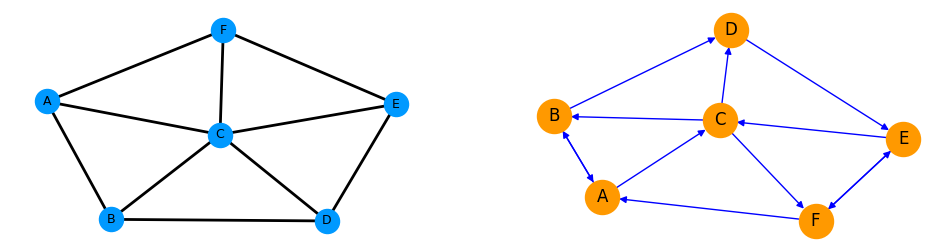

In [34]:
edges = 'AB BA CB CD AC EC CF FA BD DE EF FE'.split() # création de la liste des arêtes
netA = nx.Graph(); netA.add_edges_from(edges) # création du graphe non-orienté
netB = nx.DiGraph(); netB.add_edges_from(edges) # création du graphe orienté

mp.figure(figsize=(12,3), dpi=100) # création de la figure 'matplotlib' pour le tracé des graphes
mp.subplot(1,2,1); nx.draw(netA, with_labels=True, node_color='#09F', font_size=9, width=2)
mp.subplot(1,2,2); nx.draw(netB, with_labels=True, node_color='#F90', edge_color='#00F', node_size=600)

Si on exécute plusieurs fois la cellule précédente, on constate que le tracé obtenu est différent à chaque exécution, et qu'il est également différent entre le graphe de gauche et celui de droite, alors qu'ils ont pourtant exactement la même topologie. Ces tracés non-déterministes viennent du fait que le processus de descente de gradient s'applique à partir d'un positionnement initial des noeuds totalement aléatoire. Pour obtenir un tracé identique à chaque exécution, il suffit de forcer une valeur fixe pour le paramètre **`seed`** correspondant à la graine utilisée par le générateur aléatoire des positions initiales :

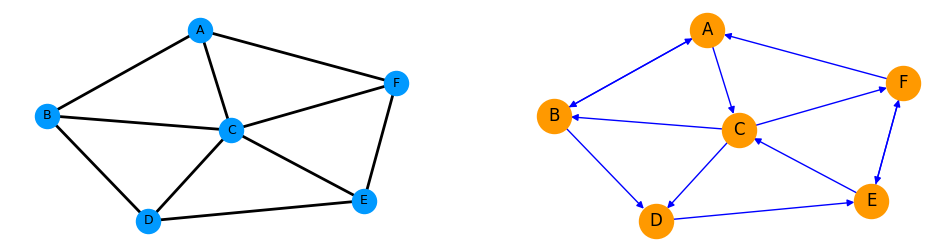

In [35]:
pos = nx.spring_layout(netA, seed=1) # on force 'seed' pour avoir les mêmes positions à chaque exécution

mp.figure(figsize=(12,3), dpi=100) # création de la figure 'matplotlib' pour le tracé des graphes
mp.subplot(1,2,1); nx.draw(netA, pos, with_labels=1, node_color='#09F', font_size=9, width=2)
mp.subplot(1,2,2); nx.draw(netB, pos, with_labels=1, node_color='#F90', edge_color='#00F', node_size=600)

Dans l'exemple précédent, les seules données stockées dans le graphe étaient les noms des noeuds. On a pu rajouter des éléments de visualisation (couleur et taille pour les noeuds, couleur et épaisseur pour les arêtes) mais ces éléments n'étaient pas directement stockés dans le graphe lui-même. Dans les cas concrets utilisés en Sciences des Données, il est nécessaire de pouvoir stocker des informations bien plus complexes, aussi bien pour les noeuds que pour les arêtes des graphes que l'on manipule. La bibliothèque **networkx** permet ainsi d'associer des données totalement arbitraires (en nombre et en nature) sous la forme d'un **dictionnaire** individuel qui sera associé à chacun des noeuds et à chacune des arêtes.

Dans l'exemple ci-dessous, on va ainsi rajouter deux propriétés, **mode** et **score**, à chaque noeud et deux autres propriétés, **weight** et **group**, à chaque arête. Ces propriétés sont indépendantes des éléments de visualisation, mais on va leur donner une représentation graphique en leur associant des propriétés visuelles pour le tracé : les valeurs de **mode** et **score** vont ainsi respectivement contrôler la couleur et la taille des noeuds, tandis que les valeurs de **weight** et **group** vont respectivement définir l'épaisseur et le style utilisé pour les arêtes :

graph.nodes.data() ➤
[('A', {'mode': 'aa', 'score': 3}), ('B', {'mode': 'bb', 'score': 5}), ('C', {'mode': 'cc', 'score': 6}), ('D', {'mode': 'aa', 'score': 2}), ('E', {'mode': 'dd', 'score': 4}), ('F', {'mode': 'bb', 'score': 3})]

graph.edges.data() ➤
[('A', 'B', {'weight': 5, 'group': 'w'}), ('A', 'C', {'weight': 2, 'group': 'y'}), ('A', 'F', {'weight': 5, 'group': 'x'}), ('B', 'C', {'weight': 4, 'group': 'z'}), ('B', 'D', {'weight': 4, 'group': 'y'}), ('C', 'D', {'weight': 3, 'group': 'w'}), ('C', 'E', {'weight': 5, 'group': 'y'}), ('C', 'F', {'weight': 2, 'group': 'x'}), ('D', 'E', {'weight': 3, 'group': 'x'}), ('D', 'F', {'weight': 3, 'group': 'z'}), ('D', 'D', {'weight': 2, 'group': 'z'}), ('E', 'F', {'weight': 4, 'group': 'w'})]


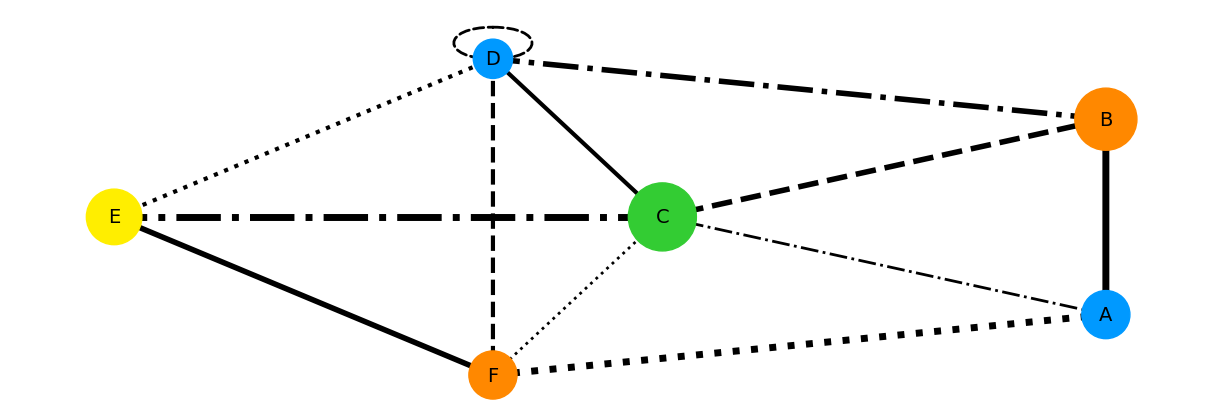

In [36]:
nodes = 'ABCDEF' # liste des noeuds
modes = 'aa bb cc aa dd bb'.split() # liste des modes (= 1ère propriété) associés aux noeuds
scores = [3, 5, 6, 2, 4, 3] # liste des scores (= 2ème propriété) associés aux noeuds
nodes = [(node, dict(mode=mode, score=score)) for node,mode,score in zip(nodes,modes,scores)]

edges = 'AB CB CD AC EC CF FA BD DE EF DF DD'.split() # liste des arêtes
weights = [5, 4, 3, 2, 5, 2, 5, 4, 3, 4, 3, 2] # liste des poids (= 1ère propriété) associés aux arêtes
groups = 'w z w y y x x y x w z z'.split() # liste des groupes (= 2ème propriété) associées aux arêtes
edges = [(*edge, dict(weight=weight, group=group)) for edge,weight,group in zip(edges,weights,groups)]

graph = nx.Graph(); graph.add_nodes_from(nodes); graph.add_edges_from(edges) # création du graphe
show("graph.nodes.data()#;; graph.edges.data()#") # affichage des propriétés stockées dans le graphe

colors = dict(zip(set(modes), '#3C3 #F80 #09F #FE0'.split())) # association d'une couleur par mode
node_colors = [colors[prop['mode']] for node,prop in graph.nodes.items()] # couleur de noeud en f° du mode
node_sizes = [400*prop['score'] for node,prop in graph.nodes.items()] # taille de noeud en f° du score

styles = dict(zip(set(groups), 'solid dashed dashdot dotted'.split())) # association d'un style par groupe
edge_widths = [prop['weight'] for *edge,prop in graph.edges.items()] # épaisseur d'arête en f° du poids
edge_styles = [styles[prop['group']] for *edge,prop in graph.edges.items()] # style d'arête en f° du groupe

# 'shell_layout' positionne les noeuds selon les couches concentriques définies par le second paramètre
pos = nx.shell_layout(graph, ['C','EFABD']) # C au centre, E/F/A/B/D autour, dans le sens trigonométrique

mp.figure(figsize=(12, 4), dpi=100) # création de la figure 'matplotlib' pour le tracé du graphe
nx.draw(graph, pos, with_labels=True, arrows=False, width=edge_widths, style=edge_styles,
  node_size=node_sizes, node_color=node_colors, edge_color='#000', font_size=14) # tracé du graphe

---
### 2 - Lecture et écriture de graphes sur disques

Le package **networkx** inclut plusieurs fonctions pour l'import/export de graphes depuis/vers des fichiers, capable de gérer plusieurs formats classiques pour le stockage de graphes. Pour les tests, on va reprendre l'exemple du fichier **`test-GML.gml`** vu dans la section B du chapitre 10, qui contient un graphe au format [**GML**](https://en.wikipedia.org/wiki/Graph_Modelling_Language) ***(Graph Modeling Language)*** :

In [37]:
gml = load('TEST/test-GML.gml','') # lecture du fichier GML en chaîne brute
show("cutcut(gml,10)#") # affichage des 10 premières et 10 dernières lignes du fichier

cutcut(gml,10) ➤
# Demo file for the GML (Graph Modeling Language) format
# Note : whitespaces and newlines are not meaningful

# 'graph' blocks define all global graph properties
graph [
  title "demo graph"
  directed 1

# 'node' blocks define all properties for one node
node [id 1 label "A1" x 100 y 300 cluster "A"]
●  ●  ●
edge [source 6 target 3 label "ab"]

node [id 7 label "XX" x 250 y 100 cluster "X"] # most blocks are single-line
edge [ # but multi-line blocks are allowed, if you prefer
  source 7 target 3 label "xa" # property values may be strings, ints or floats
  color "(0,0,255)" # non-int or non-float values must be encoded as strings
]
edge [source 7 target 6 label "xb" color "(0,255,0)"]
edge [source 7 target 7 label "xx" color "(255,0,0)"]
]


Le format GML est géré en import/export par **networkx** grâce aux fonctions **`read_gml`** et **`write_gml`**, ce qui permet de visualiser directement le graphe stocké dans le fichier, en utilisant l'ensemble des propriétés qui y sont associées (noms et positions des noeuds, labels des arêtes) :

gml.nodes.data() ➤
[('A1', {'x': 100, 'y': 300, 'cluster': 'A'}), ('A2', {'x': 200, 'y': 300, 'cluster': 'A'}), ('A3', {'x': 150, 'y': 200, 'cluster': 'A'}), ('B1', {'x': 300, 'y': 300, 'cluster': 'B'}), ('B2', {'x': 400, 'y': 300, 'cluster': 'B'}), ('B3', {'x': 350, 'y': 200, 'cluster': 'B'}), ('XX', {'x': 250, 'y': 100, 'cluster': 'X'})]

gml.edges.data() ➤
[('A1', 'A2', {'label': 'aa'}), ('A2', 'A3', {'label': 'aa'}), ('A2', 'B1', {'label': 'ab'}), ('A3', 'A1', {'label': 'aa'}), ('A3', 'B3', {'label': 'ab'}), ('B1', 'B2', {'label': 'bb'}), ('B1', 'A2', {'label': 'ab'}), ('B2', 'B3', {'label': 'bb'}), ('B3', 'B1', {'label': 'bb'}), ('B3', 'A3', {'label': 'ab'}), ('XX', 'A3', {'label': 'xa', 'color': '(0,0,255)'}), ('XX', 'B3', {'label': 'xb', 'color': '(0,255,0)'}), ('XX', 'XX', {'label': 'xx', 'color': '(255,0,0)'})]


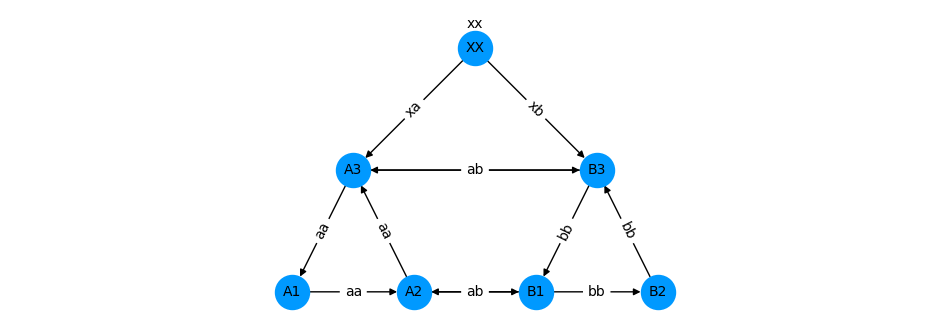

In [38]:
gml = nx.read_gml('TEST/test-GML.gml') # lecture du fichier GML par 'networkx'
show("gml.nodes.data()#;; gml.edges.data()#") # affichage de la structure interne du graphe

mp.figure(figsize=(12,4), dpi=100); mp.axis('equal') # création de la figure avec axes isométriques
pos = {node:(prop['x'], -prop['y']) for node,prop in gml.nodes.items()} # extraction des positions
nx.draw(gml, pos, with_labels=True, node_color="#09F", node_size=600, font_size=10) # tracé du graphe
edge_labels = {edge:prop['label'] for edge,prop in gml.edges.items()} # extraction des labels
nx.draw_networkx_edge_labels(gml, pos, edge_labels=edge_labels, font_size=10); # ajout des labels des arêtes

Le format [**GraphML**](http://graphml.graphdrawing.org) est une variante du format XML spécifiquement développée pour le stockage de graphes. Il s'agit de l'un des formats de fichiers les plus utilisés par les applications de manipulation de graphes, donc il est logique que le package **networkx** dispose des fonctions **`read_graphml`** et **`write_graphml`** pour l'import/export des fichiers **GraphML** :

In [39]:
nx.write_graphml(gml, 'TEST/test-GRAPHML.graphml') # conversion du graphe GML au format GraphML
grml = load('TEST/test-GRAPHML.graphml', '') # lecture de fichier GraphML en chaîne brute
show("cutcut(grml,5)#") # affichage des 5 premières et 5 dernières lignes du fichier (c'est bien du XML)

cutcut(grml,5) ➤
<?xml version='1.0' encoding='utf-8'?>
<graphml xmlns="http://graphml.graphdrawing.org/xmlns" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd"><key id="d5" for="edge" attr.name="color" attr.type="string"/>
<key id="d4" for="edge" attr.name="label" attr.type="string"/>
<key id="d3" for="node" attr.name="cluster" attr.type="string"/>
<key id="d2" for="node" attr.name="y" attr.type="long"/>
●  ●  ●
<edge source="XX" target="XX">
  <data key="d4">xx</data>
  <data key="d5">(255,0,0)</data>
</edge>
</graph></graphml>


Comme on le voit dans les exemples de code précédents, les méthodes **`nodes.data()`** et **`edges.data()`** retournent des dictionnaires contenant l'ensemble des données associées aux noeuds et aux arêtes du graphe. Par conséquent, à partir du moment où un graphe est stockée dans une structure **`networkx`**, il est très facile de le convertir au format JSON, avec le processus détaillé dans le chapitre 10 mettant en oeuvre la fonction **`py2js`** importée du module standard **`json`** :

In [40]:
from json import dumps as py2js # import de la fonction de conversion Python vers JSON

json = dict(nodes=list(gml.nodes.data()), edges=list(gml.edges.data())) # fusion des noeuds et des arêtes
show("py2js(json)#") # affichage de la chaîne JSON résultante

py2js(json) ➤
{"nodes": [["A1", {"x": 100, "y": 300, "cluster": "A"}], ["A2", {"x": 200, "y": 300, "cluster": "A"}], ["A3", {"x": 150, "y": 200, "cluster": "A"}], ["B1", {"x": 300, "y": 300, "cluster": "B"}], ["B2", {"x": 400, "y": 300, "cluster": "B"}], ["B3", {"x": 350, "y": 200, "cluster": "B"}], ["XX", {"x": 250, "y": 100, "cluster": "X"}]], "edges": [["A1", "A2", {"label": "aa"}], ["A2", "A3", {"label": "aa"}], ["A2", "B1", {"label": "ab"}], ["A3", "A1", {"label": "aa"}], ["A3", "B3", {"label": "ab"}], ["B1", "B2", {"label": "bb"}], ["B1", "A2", {"label": "ab"}], ["B2", "B3", {"label": "bb"}], ["B3", "B1", {"label": "bb"}], ["B3", "A3", {"label": "ab"}], ["XX", "A3", {"label": "xa", "color": "(0,0,255)"}], ["XX", "B3", {"label": "xb", "color": "(0,255,0)"}], ["XX", "XX", {"label": "xx", "color": "(255,0,0)"}]]}


---
### 3 - Graphe des départements

Comme on l'a vu dans la section C ci-dessus, le [**théorème des 4 couleurs**](https://fr.wikipedia.org/wiki/Th%C3%A9or%C3%A8me_des_quatre_couleurs) prouve qu'il suffit de quatre couleurs différentes pour colorier n'importe quelle carte plane découpée en régions connexes, en imposant que deux régions adjacentes reçoivent toujours deux couleurs distinctes. Ce théorème possède une version duale qui indique qu'***il suffit de quatre couleurs pour colorier les noeuds de n'importe quel graphe planaire*** avec des couleurs différentes pour deux noeuds adjacents. La section C utilisait comme exemple, le fichier CSV **`dep.csv`** contenant la liste des voisins pour chacun des 96 départements de la France métropolitaine. On va réutiliser le même fichier et montrer qu'avec le package **networkx**, le code à produire pour la coloration et la visualisation de ce graphe est nettement plus simple :

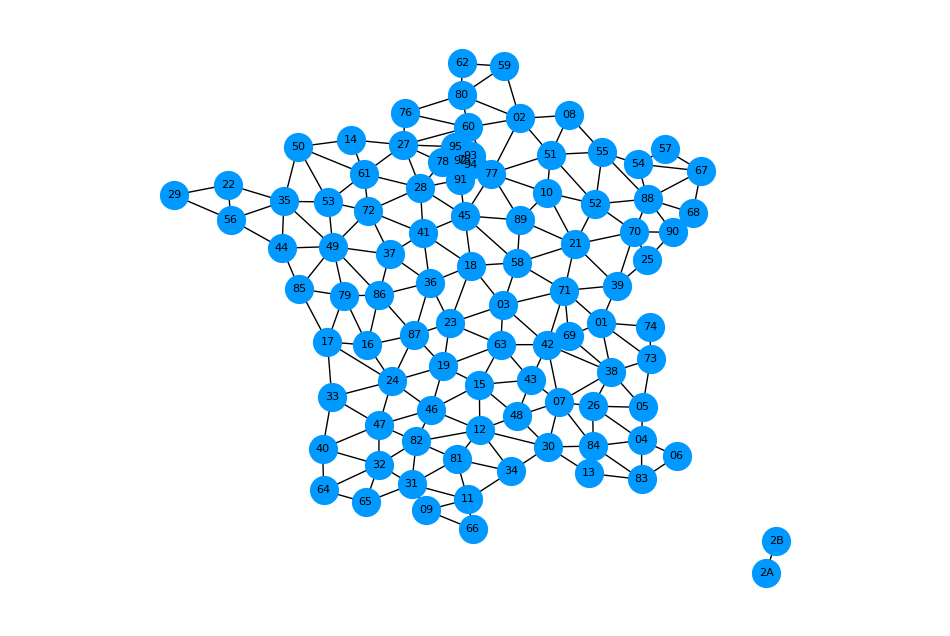

In [41]:
deps = [line.split(',') for line in load('TEST/dep.csv')] # lecture du fichier CSV des départements
edges = [(code,link) for code,lon,lat,links in deps for link in links.split()] # création des arêtes
pos = {code:(float(lon), 1.3*float(lat)) for code,lon,lat,links in deps} # extraction des positions

graph = nx.Graph(); graph.add_edges_from(edges) # création du graphe
mp.figure(figsize=(12,8), dpi=100); mp.axis('equal') # création de la figure avec axes isométriques
nx.draw(graph, pos, with_labels=True, node_size=400, node_color='#09F', font_size=8) # tracé du graphe

Le package **networkx** fournit une fonction **`greedy_color`** qui permet de déterminer des couleurs symboliques (sous forme d'un indice numérique) pour les noeuds d'un graphe quelconque, en garantissant que deux nodes voisins vont recevoir une couleur différente. A la différence de ce qui a été fait précédemment avec le package **`python-constraint`**, l'algorithme mis en oeuvre ne garantit pas expliciement que la coloration renvoyée utilisera uniquement quatre couleurs, mais la fonction propose plusieurs heuristiques que l'on peut choisir via le paramètre **`strategy`**, et l'heuristique **`smallest_last`** permet d'obtenir presque systématiquement une coloration à quatre couleurs dans le cas d'un graphe planaire :

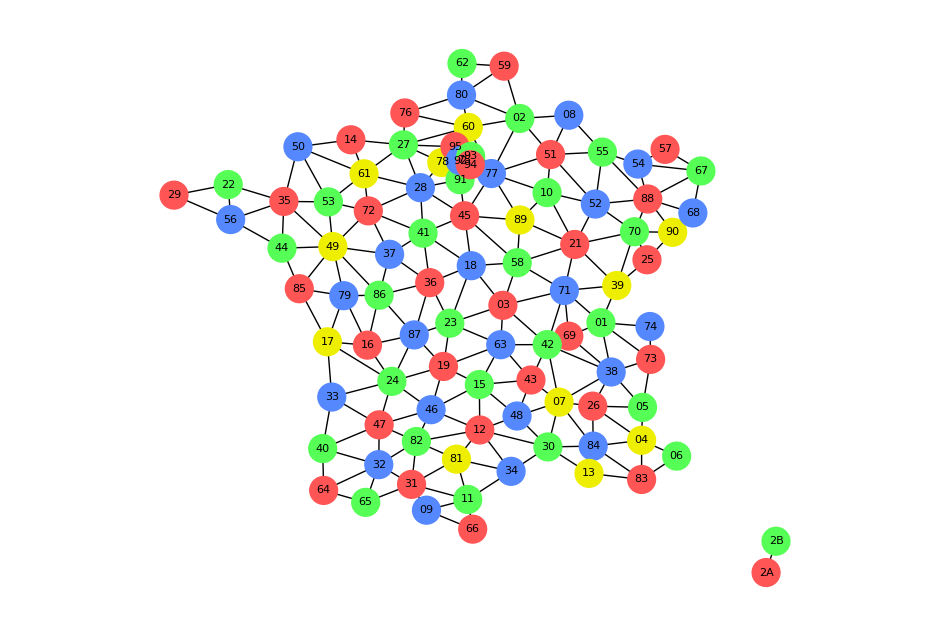

In [42]:
colors = '#F55 #5F5 #58F #EE0'.split() # création de la palette des 4 couleurs au format #RGB
node_colors = nx.coloring.greedy_color(graph, strategy='smallest_last') # coloration des noeuds du graphe
node_colors = [colors[node_colors[node]] for node in graph.nodes] # affectation des couleurs de la palette

mp.figure(figsize=(12, 8), dpi=100); mp.axis('equal') # création de la figure avec axes isométriques
nx.draw(graph, pos, with_labels=True, node_size=400, node_color=node_colors, font_size=8) # tracé

---
### 4 - Affichage et résolution de labyrinthes

Le dernier exemple destiné à illustrer les fonctionnalités du package **networkx** va reprendre le principe de l'exercice **C5** sur l'affichage et la résolution de labyrinthes, mais en reformulant le problème comme une manipulation de graphes. Les fichiers **`mazeN.txt`**, utilisés dans les feuilles d'exercices B et C, contiennent une série de [**labyrinthes parfaits**](https://fr.wikipedia.org/wiki/Mod%C3%A9lisation_math%C3%A9matique_d%27un_labyrinthe) de différentes tailles, définis par une grille composée de lettres (**A** pour les murs, **B** pour les couloirs).

On va écrire une fonction **`make_graph(maze, char)`** permettant de générer un graphe en récupérant les coordonnées des cases de la grille **`maze`** qui contiennent le caractères **`char`** et en identifiant les relations de voisinage entre les caractères identiques. Si on veut simplement calculer le chemin optimal dans le labyrinthe, il suffit de générer le graphe des couloirs. Par contre, si on veut afficher le labyrinthe, il faut également générer le graphe des murs pour que la figure soit compréhensible. Dans le cas des labyrinthes parfaits, le graphe des murs possède systématiquement deux composantes connexes qui séparent l'ensemble des murs en deux familles : les murs à droite et les murs à gauche du chemin optimal. On peut récupérer ces deux composantes avec la fonction **`connected_components`** et les visualiser avec deux couleurs différentes :

In [43]:
def make_graph(maze, char):
  """generate graph by searching connected occurrences of 'char' in 'maze'"""
  graph = nx.Graph(); X, Y = len(maze[0]), len(maze) # get horizontal and vertical sizes of maze
  pos = [(x,Y-y-1) for y in range(Y) for x in range(X) if maze[y][x] == char] # extract positions of 'char'
  nodes = dict(zip(pos, range(len(pos)))) # generate dictionary containing node positions and node IDs
  for (x,y),n in nodes.items(): # loop over nodes
    graph.add_node(n, pos=(x,y)) # add current node in graph, storing its position as attribute 'pos'
    if (x,y+1) in nodes: graph.add_edge(n, nodes[x,y+1]) # add vertical edge to north from current node
    if (x+1,y) in nodes: graph.add_edge(n, nodes[x+1,y]) # add horizontal edge to east from current node
  return graph

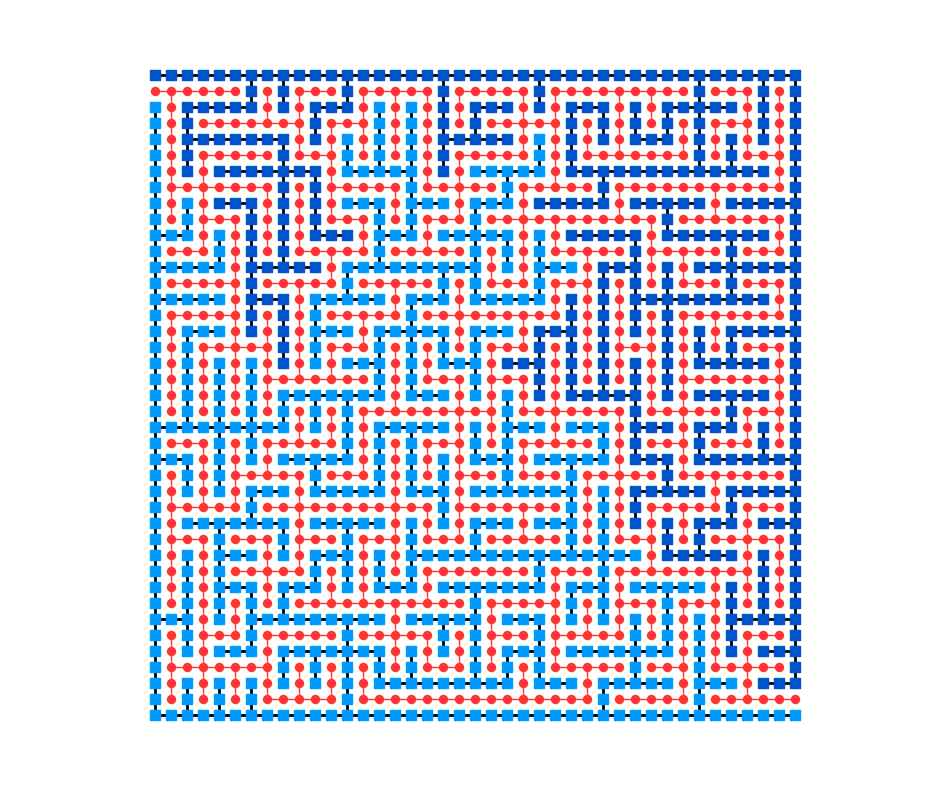

In [44]:
maze = load('DATA/maze2.txt') # lecture du labyrinthe et stockage sous forme d'une liste de chaînes
netA = make_graph(maze, 'A') # création du graphe des murs (= cases 'A')
netB = make_graph(maze, 'B') # création du graphe des couloirs (= cases 'B')
posA = nx.get_node_attributes(netA, 'pos') # extraction des positions des murs
posB = nx.get_node_attributes(netB, 'pos') # extraction des positions des couloirs

# le graphe des murs d'un labyrinthe parfait possède 2 composantes connexes (murs à droite, murs à gauche)
L, R = nx.connected_components(netA) # extraction des 2 composantes connexes L (= left) et R (= right)
netL, netR = netA.subgraph(L).copy(), netA.subgraph(R).copy() # création des sous-graphes associés

mp.figure(figsize=(12,10), dpi=100); mp.axis('equal') # création de la figure avec axes isométriques
nx.draw(netL, posA, node_size=55, node_shape='s', node_color='#05C', width=2) # murs à gauche en bleu foncé
nx.draw(netR, posA, node_size=55, node_shape='s', node_color='#09F', width=2) # murs à droite en bleu clair
nx.draw(netB, posB, node_size=33, node_color='#F33', edge_color='#F33', width=1) # couloirs en rouge

Une fois le graphe des couloirs construit, la recherche du chemin optimal dans le labyrinthe consiste à trouver le chemin le plus court dans ce graphe, entre le noeud correspondant au point d'entrée et celui correspondant au point de sortie (pour les labyrinthes stockés dans les fichiers **`mazeN.txt`**, le point d'entrée sera toujours le premier noeud du graphe des couloirs, et le point de sortie, toujours le dernier noeud de ce graphe). Le package **networkx** fournit la fonction **`shortest_path`** qui implémente l'[**algorithme de Dijkstra**](https://fr.wikipedia.org/wiki/Algorithme_de_Dijkstra), et qui répond donc exactement au problème à résoudre :

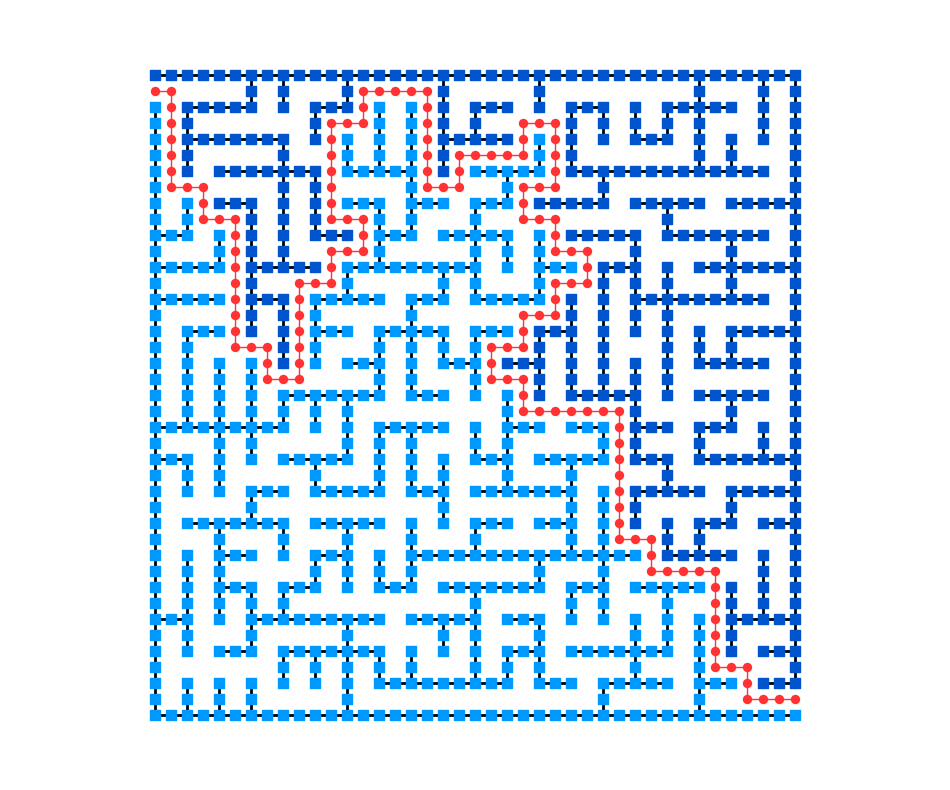

In [45]:
source, target = 0, len(posB)-1 # indices des positions d'entrée et de sortie du labyrinthe
pnodes = nx.shortest_path(netB, source=source, target=target) # calcul du chemin optimal par Dijkstra
pedges = list(zip(pnodes[:-1], pnodes[1:])) # création des arêtes du chemin (lien entre noeuds successifs)
path = nx.Graph(); path.add_edges_from(pedges) # création du graphe correspondant au chemin optimal

mp.figure(figsize=(12,10), dpi=100); mp.axis('equal') # création de la figure avec axes isométriques
nx.draw(netL, posA, node_size=55, node_shape='s', node_color='#05C', width=2) # murs à gauche en bleu foncé
nx.draw(netR, posA, node_size=55, node_shape='s', node_color='#09F', width=2) # murs à droite en bleu clair
nx.draw(path, posB, node_size=33, node_color='#F33', edge_color='#F33', width=1) # chemin optimal en rouge

Sur la figure obtenue, on peut vérifier visuellement une propriété remarquable des labyrinthes parfaits : le chemin optimal va systématiquement longer les deux composantes connexes du graphe des murs. Avec les couleurs utilisées ici, le marcheur va toujours avoir un mur bleu sombre à sa gauche et un mur bleu clair à sa droite. Il ne rentre jamais dans un couloir où les murs de droite et de gauche ont la même couleur.

---
Dans le chapitre 12, les quatre graphes **`netL, netR, netB, path`**, obtenus à partir de ce labyrinthe vont être réutilisés, manipulés et visualisés avec les outils fournis par la bibliothèque **`pyvis`**, donc pour éviter d'avoir à les regénérer, on va les sauvegarder dans un fichier. Pour cela, on pourrait évidemment exporter les graphes dans les formats classiques mentionnés plus haut, comme GML ou GraphML. Mais ces formats ont l'inconvénient de ne pouvoir stocker qu'un seul graphe par fichier, ce qui n'est pas idéal dans notre cas. Une alternative bien plus efficace est d'utiliser le module **`pickle`** (cf. section E4 du chapitre 3) qui permet de stocker n'importe quelle structure de données Python. Donc l'opération la plus simple consiste à regrouper les quatre graphes dans un tuple unique, avant de le sauvegarder avec la fonction **`dump`** du module **`pickle`** :

In [46]:
import pickle as pkl

with open('TEST/maze.pkl','wb') as file: # ouverture du fichier 'maze.pkl' en mode 'write binary' pour pickle
  pkl.dump((netL, netR, netB, path), file) # stockage des 4 graphes, réunis en tuple, au format 'pickle'

<div style="padding:8px; margin:0px -20px; color:#FFF; background:#06D; text-align:right">● ● ● </div>